In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scienceplots
import seaborn as sns
from multiprocessing import Pool
from pprint import pprint
from IPython.display import clear_output

import os
from tqdm import tqdm
import json
os.chdir("../")
import src.utils as utils
import src.envs as envs
import src.models as mm

print(os.getcwd())
import main
from scipy.ndimage import convolve1d

from src.utils import setup_logger
logger = setup_logger(level=2)
logger(f"{logger}")

2024-12-11 23:05:25 | LoggerWrapper(name=MAIN,level=2, debugging=True, warning=True)


/Users/daniekru/Research/lab/minBandit


In [2]:
class Settings:

    verbose = False
    rounds = 2
    trials = 2
    reps = 10
    K = 10
    model = None
    load = True
    plot = False
    env = "v0"
    multiple = 1
    visual = False
    save = True
    idx = 4

---
## **single main**

#### study I

In [4]:
params = utils.load_model(idx=None)
pprint(params)

{0: '6_best.json',
 1: '14_best.json',
 2: '12_best.json',
 3: '18_best.json',
 4: '20_best.json',
 5: '1_best.json',
 6: '26_best.json',
 7: '16_best.json',
 8: '2_best.json',
 9: '10_best.json',
 10: '22_best.json',
 11: '8_best.json',
 12: '3_best.json',
 13: '24_best.json'}


Enter the model number:  6


{'alpha': 1.4,
 'alpha_lr': 2.9,
 'beta': 3.1,
 'beta_lr': 8.1,
 'dur_post': 2256,
 'dur_pre': 2712,
 'gain': 0.3,
 'lr': 0.022,
 'lr_function': 'gaussian',
 'mu': -1.1,
 'mu_lr': -0.6,
 'r': 0.93,
 'r_lr': 0.07,
 'sigma': 2.3,
 'sigma_lr': 6.0,
 'tau_u': 9,
 'tau_v': 42,
 'threshold': 2.52,
 'value_function': 'gaussian',
 'w_max': 3.8}


In [7]:
record = {}

settings1 = Settings()
settings1.rounds = 2000
settings1.trials = 2
settings1.reps = 1
settings1.verbose = True
settings1.env = "v0"
settings1.load = True
settings1.idx = 6

""" run """
Ks = [10]
record = {}
for i, k in tqdm(zip(range(len(Ks)), Ks)):
    settings1.K = k
    results, model = main.main(args=settings1, return_model=True)
    record[str(k)] = results

print("done")

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:35<00:00, 47.74s/it]
1it [01:35, 95.49s/it]

done


In [20]:
results.keys()

dict_keys(['rewards_list', 'chance_list', 'optimal_list', 'score', 'chance', 'upper_bound', 'selection_list', 'weights'])

**performance**

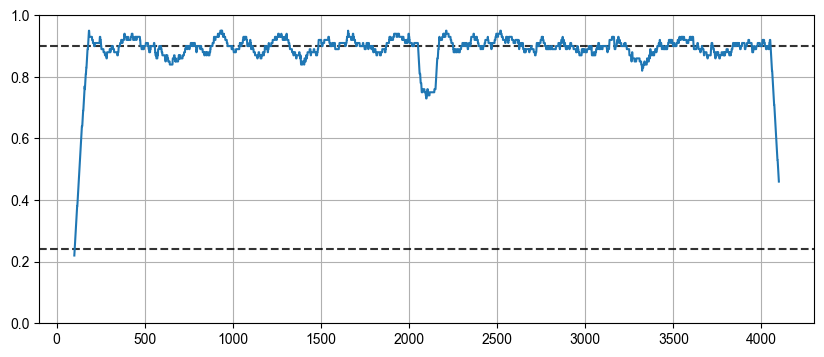

In [8]:
size = 100
scores = np.convolve(np.array(results['rewards_list']).flatten(), np.ones(size), mode="same") / size

plt.figure(figsize=(10, 4))
plt.axhline(results['upper_bound'], linestyle="--", color='k', alpha=0.8)
plt.axhline(results['chance'], linestyle="--", color='k', alpha=0.8)
plt.plot(range(size, size+len(scores)), scores)
plt.ylim((0, 1.))
plt.grid()
plt.show()

**analysis**

In [9]:
w = np.array(results["weights"])
w.shape

(10, 4000)

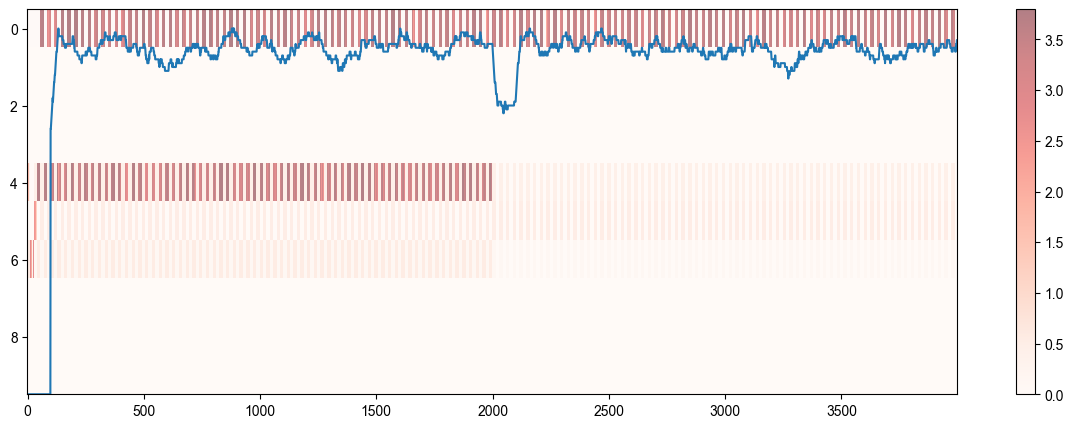

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(w, aspect="auto", interpolation="nearest", cmap="Reds", alpha=0.5)

size = 100
sc = np.convolve(np.array(results["rewards_list"]).flatten(), np.ones(size), mode='valid') / size
sc = [0] * (size - 1) + sc.tolist()
plt.plot(range(len(sc)), settings1.K-np.array(sc)*settings1.K - 0.5)
plt.colorbar()
plt.show()

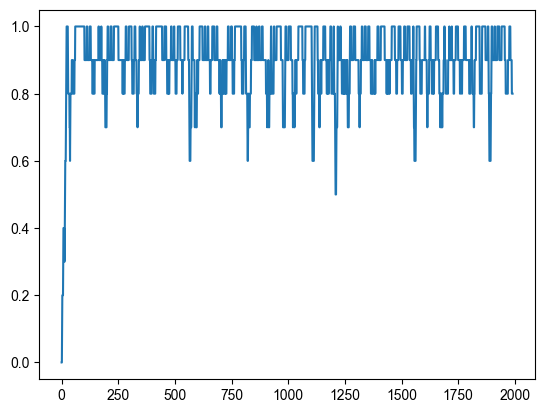

In [11]:
size = 10
sc = np.convolve(results["rewards_list"][1], np.ones(size), mode='valid') / size

plt.plot(range(len(sc)), sc);

#### study II

2024-12-08 23:04:43 | KABv0
 50%|████████████▌            | 1/2 [00:50<00:50, 50.85s/it]/Users/daniekru/Research/lab/minBandit/src/models.py:338: RuntimeWarning: overflow encountered in add
  self._W[self._choice] += dw
100%|█████████████████████████| 2/2 [01:40<00:00, 50.46s/it]


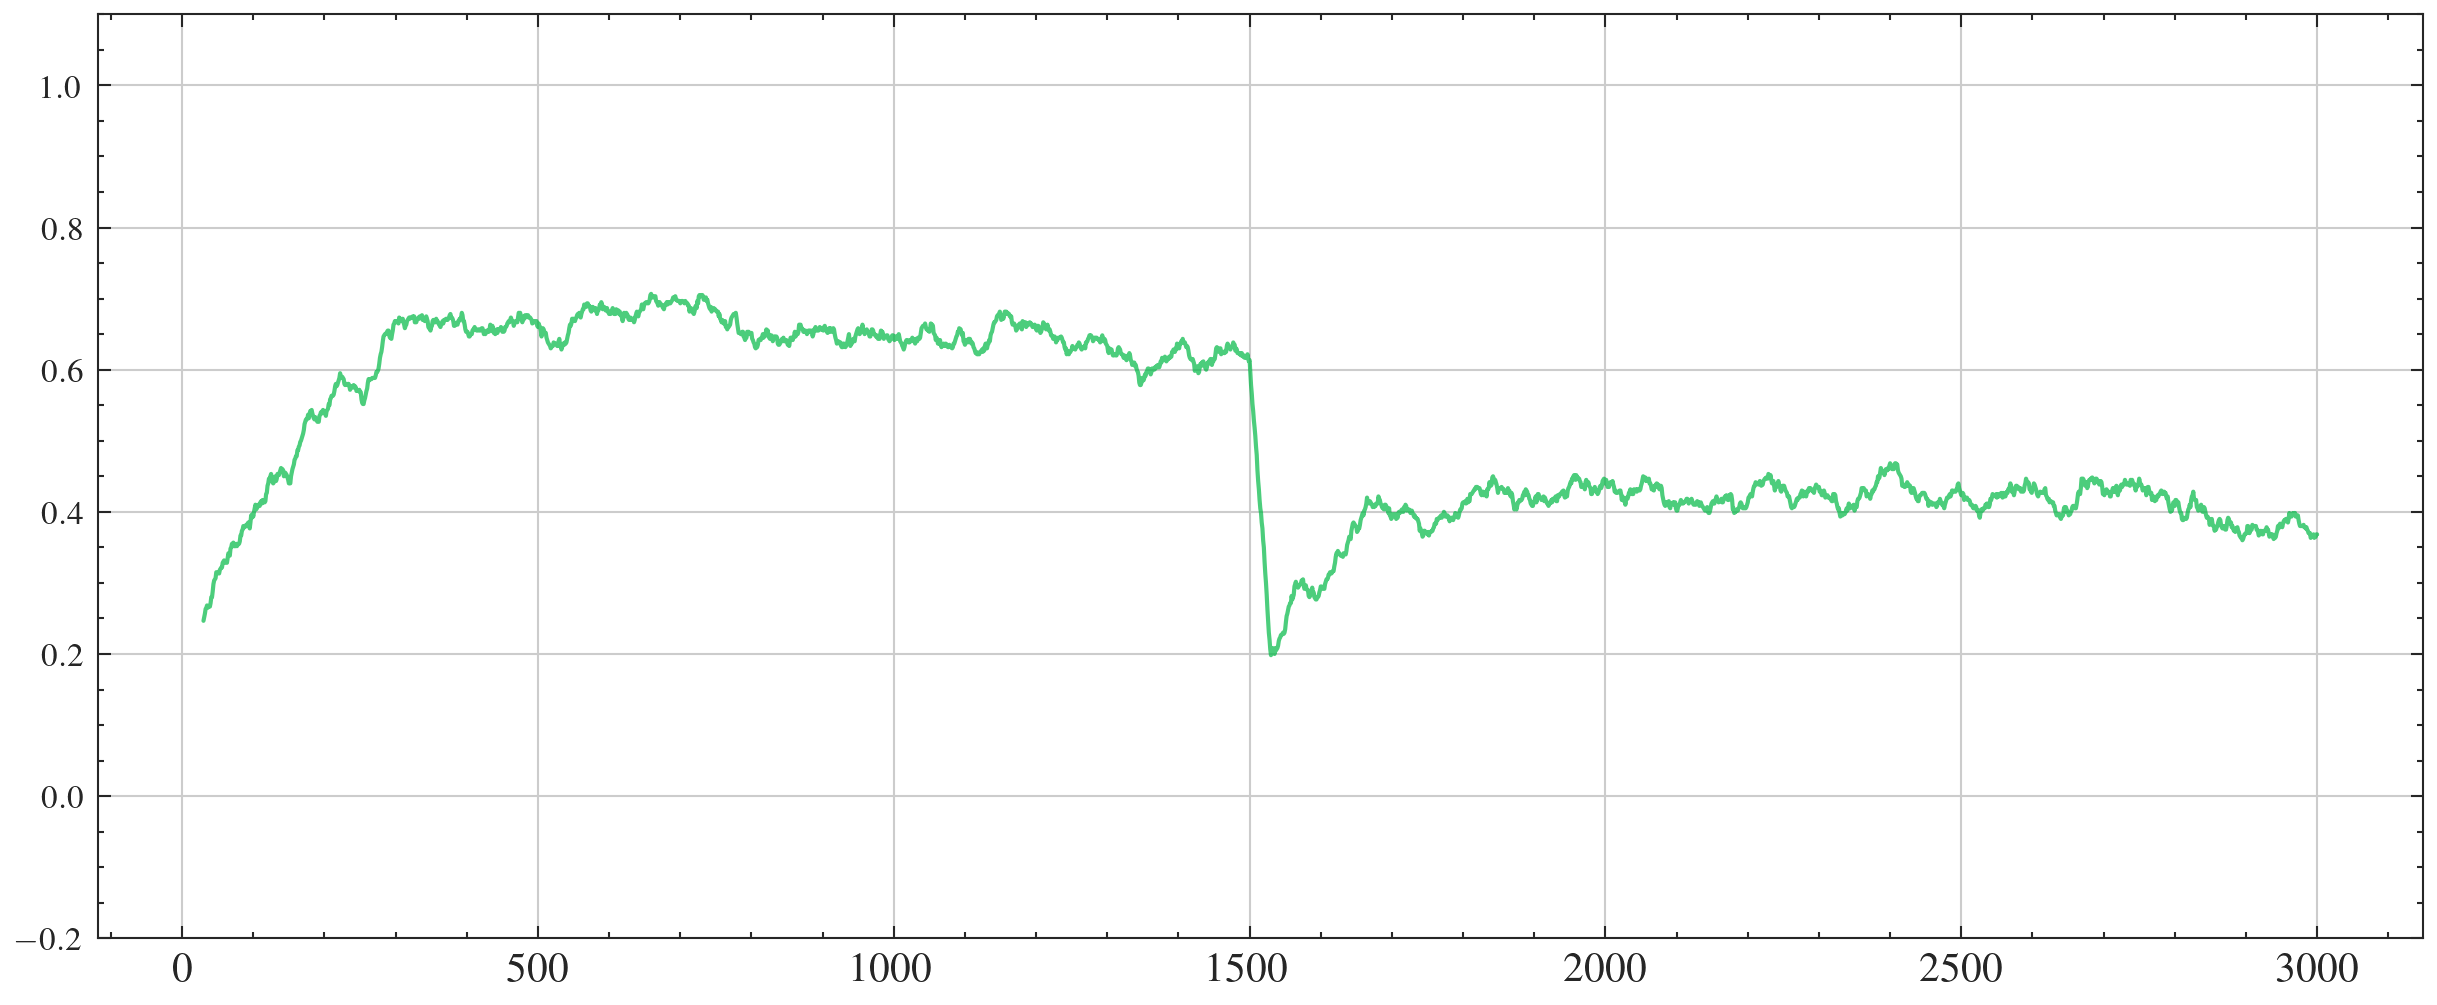

In [469]:
""" settings """

K = 100
nb_trials = 2
nb_rounds = 1500

""" env """
probabilities_set = utils.make_probability_set(K=K,
                                         nb_trials=nb_trials,
                                         fixed_p=0.9,
                                         normalize=False)

env = envs.KABv0(K=K,
                 probabilities_set=probabilities_set,
                 verbose=False)
logger(env)

""" model """
params = utils.load_model(idx=None)
params["K"] = K
params["track_weights"] = True



size = 30
size_s = size
DWY = None
SY = None

reps = 20
for i in range(reps):

    model = mm.Model(**params)
    results = envs.trial(model=model,
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         verbose=True)
    dw = model.get_delta_record()
    if i == 0:
        DWY = np.convolve(dw.flatten(), np.ones(size), mode="valid")
        SY = np.convolve(np.array(results["rewards_list"]).flatten(), np.ones(size_s), mode="valid")
        continue
    DWY += np.convolve(dw.flatten(), np.ones(size), mode="valid")
    SY += np.convolve(np.array(results["rewards_list"]).flatten(), np.ones(size_s), mode="valid")

dwy = DWY /reps
sy = SY / reps

plt.figure(figsize=(10, 4))
plt.plot(range(size, len(dwy)+size), DWY/size, lw=1., alpha=0.9)
plt.plot(range(size_s, len(sy)+size_s), sy/size_s, alpha=0.7)
plt.ylim((-0.2, 1.1))

plt.grid()
plt.show()

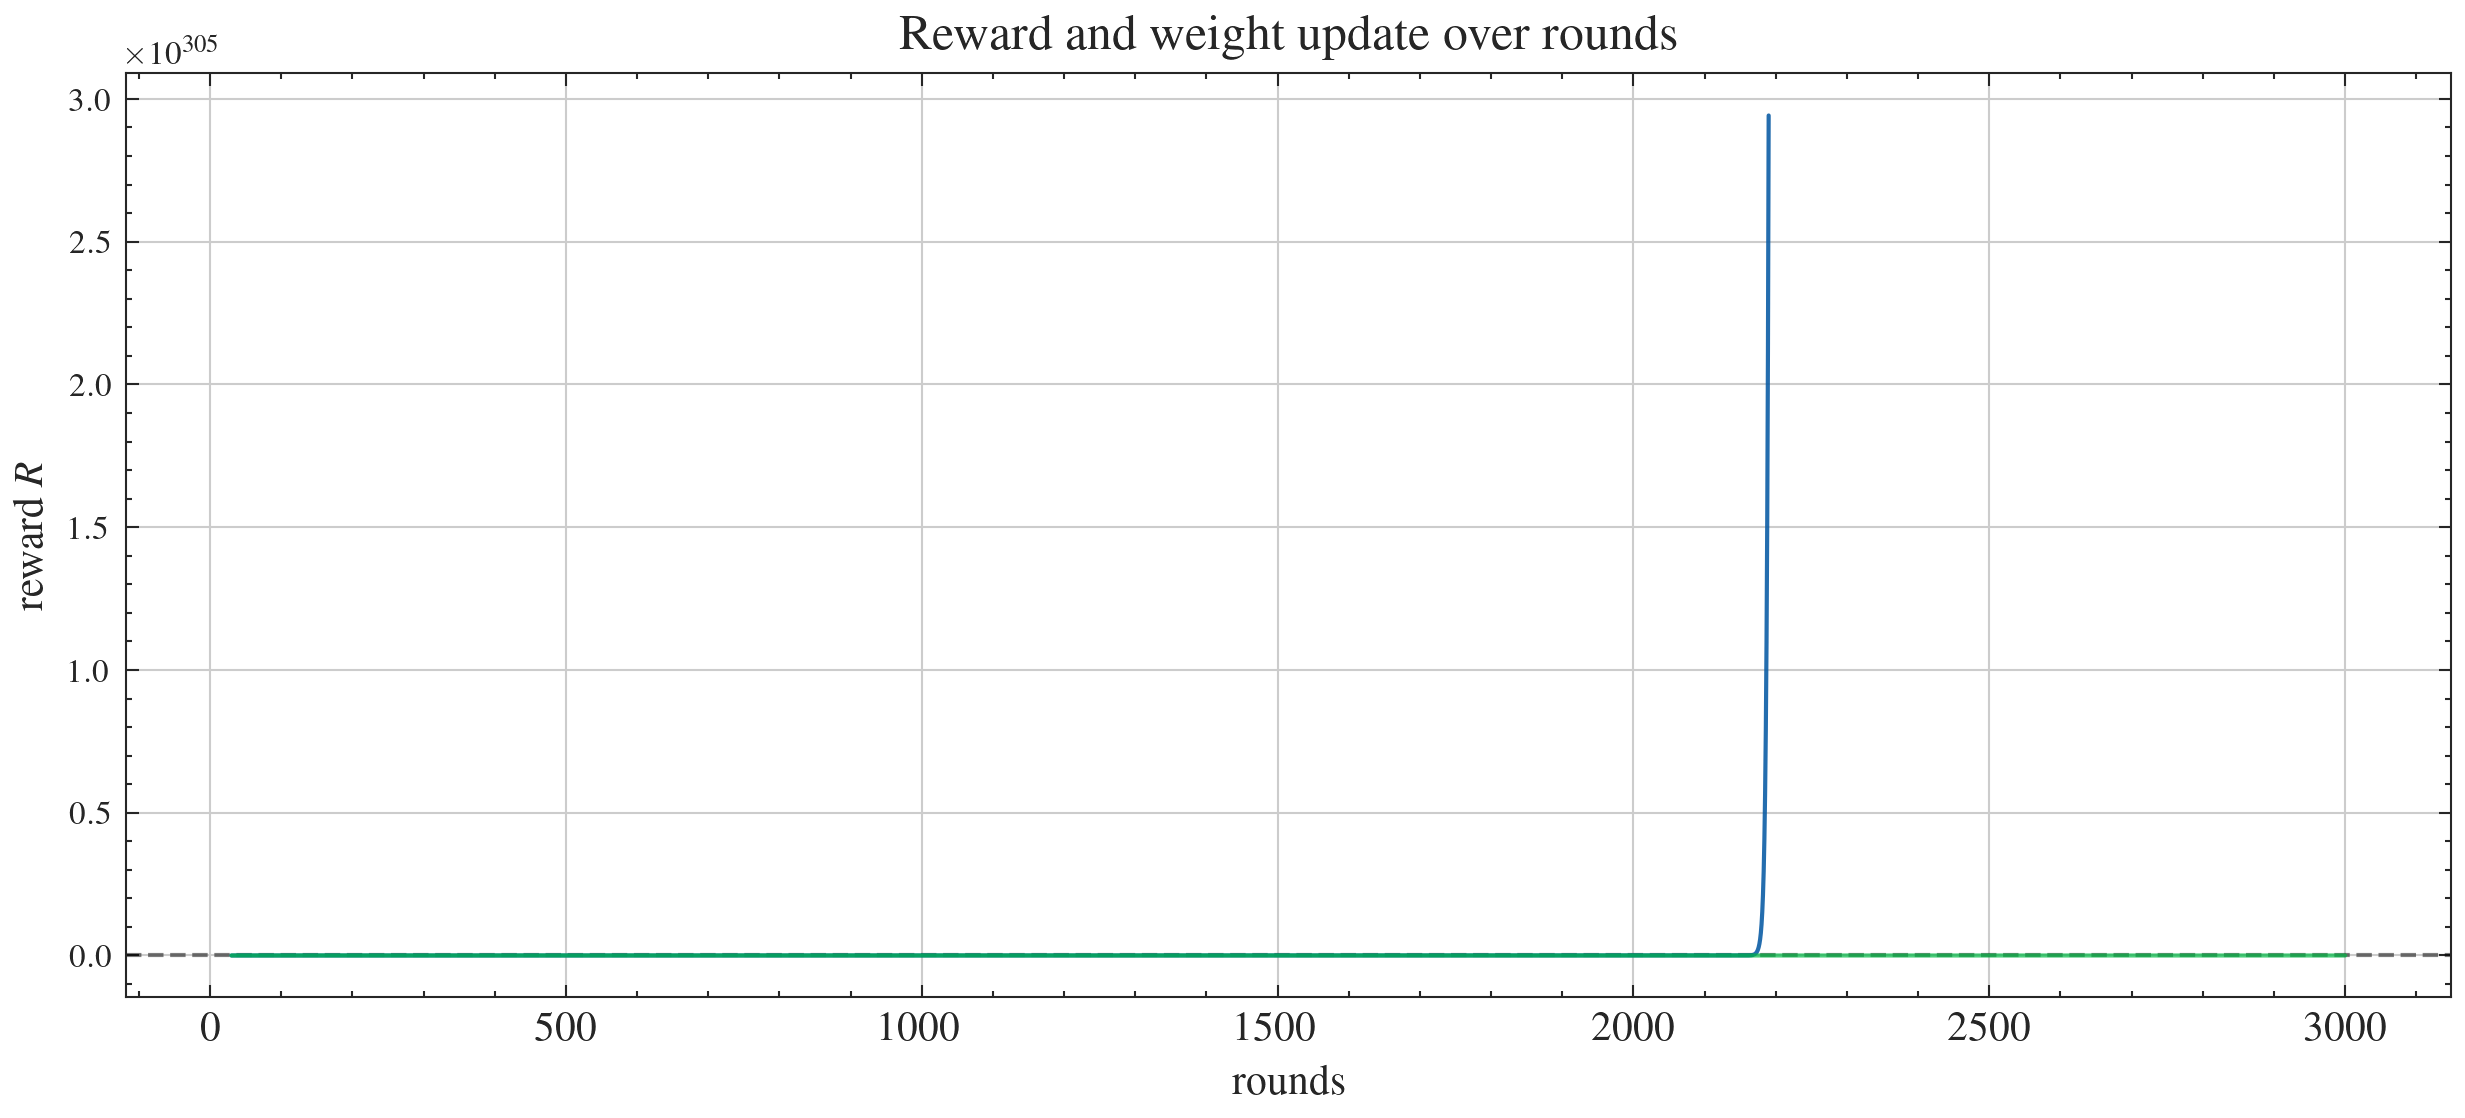

In [472]:
plt.figure(figsize=(10, 4))
plt.axhline(0.9, color="black", linestyle="--", alpha=0.5, label="max reward")
plt.plot(range(size, len(dwy)+size), dwy/size, lw=1., alpha=0.9, label="weight update")
plt.plot(range(size_s, len(sy)+size_s), sy/size_s, alpha=0.7, label="cumulative reward")

plt.xlabel("rounds")
plt.ylabel("reward $R$")
#plt.ylabel("update $\\Delta W$") # second y-axis

plt.title("Reward and weight update over rounds")
#plt.ylim((-0.2, 1.))
plt.grid()
plt.show()

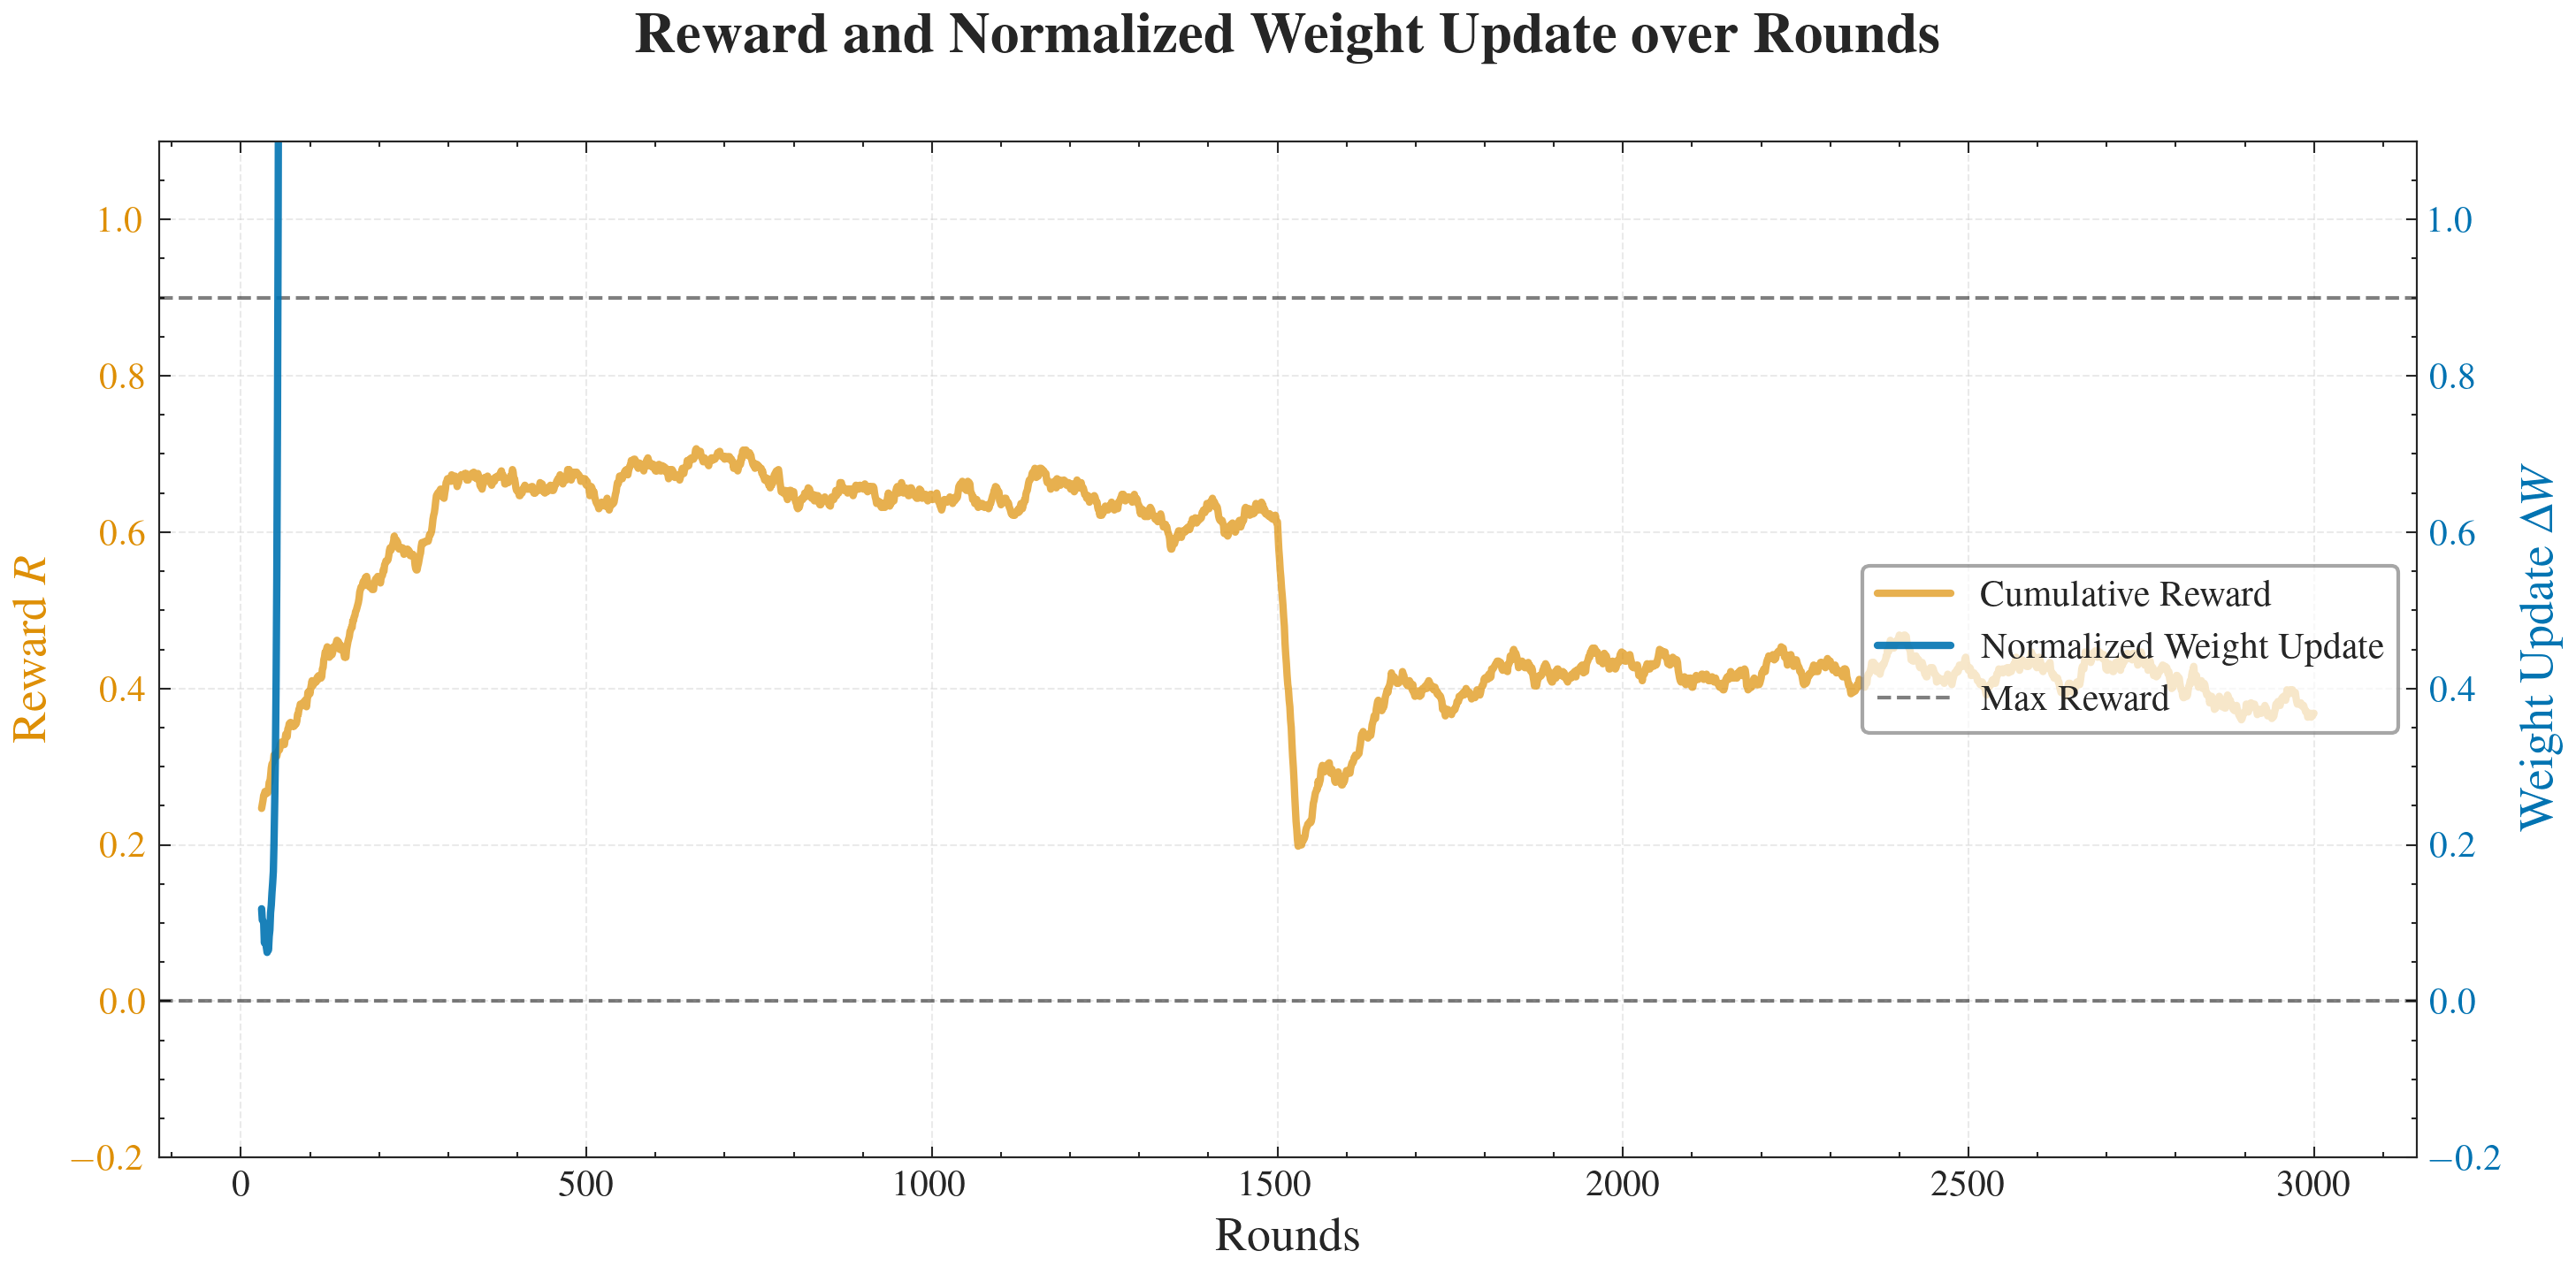

In [473]:
# Set the style and font for a professional, publication-ready look
plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 13,
    'font.size': 13,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Color palette
colors = sns.color_palette("colorblind", 3)

# First y-axis (Reward)
ax1.set_xlabel(r"Rounds", fontweight='bold')
ax1.set_ylabel(r"Reward $R$", color=colors[1], fontweight='bold')
ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.set_ylim(-0.2, 1.1)

# Horizontal line for max reward
ax1.axhline(0.9, color="black", linestyle="--", alpha=0.5, 
            label="Max Reward", linewidth=1.)

# Cumulative reward plot
reward_line, = ax1.plot(range(size_s, len(sy)+size_s), sy/size_s, 
                        color=colors[1],
                        lw=2, 
                        alpha=0.7, 
                        label="Cumulative Reward")

# Second y-axis (Weight Update)
ax2 = ax1.twinx()
ax2.set_ylabel(r"Weight Update $\Delta W$", color=colors[0], fontweight='bold')
ax2.tick_params(axis='y', labelcolor=colors[0])
ax2.set_ylim(-0.2, 1.1)


# Normalize weight update to make it more explicit
#dwy_normalized = (dwy/size - np.mean(dwy/size)) / np.std(dwy/size)

# Weight update plot with normalization
update_line, = ax2.plot(range(size, len(dwy)+size), dwy/size, 
                        color=colors[0],
                        lw=2, 
                        alpha=0.9, 
                        label="Normalized Weight Update")

# Add reference lines for normalized weight update
ax2.axhline(0, color='black', linewidth=1, alpha=0.5, linestyle='--')
#ax2.axhline(1, color='black', linewidth=1, alpha=0.3, linestyle=':')
#ax2.axhline(-1, color='black', linewidth=1, alpha=0.3, linestyle=':')

# Title
fig.suptitle(r'\textbf{Reward and Normalized Weight Update over Rounds}')

# Grid
ax1.grid(alpha=0.4, linestyle='--')

# Combined legend
lines = [reward_line, update_line, ax1.get_lines()[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='right', 
           frameon=True, 
           fancybox=True, 
           framealpha=0.7, 
           edgecolor='gray')

# Adjust layout and save
plt.tight_layout()
#plt.savefig('reward_update_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

### run

In [18]:
settings1 = Settings()
settings1.rounds = 2000
settings1.trials = 1
settings1.reps = 5
settings1.verbose = True
settings1.idx = 16
settings1.load = True
settings1.env = "v0"
settings1.K = 1000

logger(f"reps:   {settings1.reps}")
logger(f"trials: {settings1.trials}")
logger(f"rounds: {settings1.rounds}")
logger(f"env:    {settings1.env}")

# parameters
K = settings1.K
nb_rounds = settings1.rounds
nb_trials = settings1.trials
nb_reps = settings1.reps
verbose = settings1.verbose
env_type = settings1.env

# define proababilities set
probabilities_set = []
for i in range(nb_trials):
    p = np.around(np.random.uniform(0.05, 0.3, K), 2)
    p[i%K] = 0.9
    # p[np.random.randint(0, K)] = 0.9
    probabilities_set += [p.tolist()]

probabilities_set = np.array(probabilities_set)

# define the environment
if env_type == "driftv0":
    env = envs.KABdriftv0(K=K,
                          probabilities_set=probabilities_set,
                          verbose=verbose,
                          tau=5)
elif env_type == "driftv1":
    env = envs.KABdriftv1(K=K,
                          verbose=verbose,
                          tau=100,
                          normalize=True,
                          fixed_p=0.9)
elif env_type == "sinv0":
    frequencies = np.linspace(0, 0.4, K)
    env = envs.KABsinv0(K=K,
                        frequencies=frequencies,
                        normalize=True,
                        verbose=verbose)
else:
    env = envs.KABv0(K=K,
                     probabilities_set=probabilities_set,
                     verbose=verbose)

if verbose:
    logger.info(f"%env: {env}")

# define models
if settings1.load:
    # params = utils.load_model(idx=args.idx,
    #                           verbose=verbose)

    idx = settings1.idx if settings1.idx is not None else None
    params = utils.load_model(idx=idx)
    # params["K"] = K
    params["K"] = K
    #params['dur_pre'] = 1000
    #params['dur_post'] = 1000

else:
    params = {
        "K": K,
        "dur_pre": 2000,
        "dur_post": 2000,
        "lr": 0.1,
        "gain": 1.,
        "threshold": 0.5,
        "alpha": 0.,
        "beta": 1.,
        "mu": 0.,
        "sigma": 1.,
        "r": 1.,
        "alpha_lr": 0.1,
        "beta_lr": 0.1,
        "mu_lr": 0.1,
        "sigma_lr": 0.1,
        "r_lr": 0.1,
        "w_max": 5.,
        "value_function": "gaussian",
        "lr_function": "gaussian",
    }

model_list = [
    #mm.ThompsonSampling(K=K),
    #mm.EpsilonGreedy(K=K, epsilon=0.1),
    #mm.UCB1(K=K),
    mm.Model(**params)
]

# run
results = envs.trial_multiple_models(
                     models=model_list,
                     environment=env,
                     nb_trials=nb_trials,
                     nb_rounds=nb_rounds,
                     nb_reps=nb_reps,
                     verbose=settings1.verbose)

logger(f"{results['names'][0]}:\t{results['score_list'][0][0]}")

results.keys(), results['reward_list'].shape

2024-12-11 22:43:52 | reps:   5
2024-12-11 22:43:52 | trials: 1
2024-12-11 22:43:52 | rounds: 2000
2024-12-11 22:43:52 | env:    v0
2024-12-11 22:43:52 | %env: KABv0
2024-12-11 22:43:52 | Invalid parameters for Model, using Modelv2 instead
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [16:00<00:00, 192.00s/it]
2024-12-11 22:59:52 | `Model.v2`:	[0.21]


(dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'names']),
 (1, 5, 1, 2000))

In [34]:
for i in range(4):
    print(f"{results['names'][i]}:\t{results['score_list'][i][0]}")
    break

`Model.v2`:	[0.9]


### analysis

ValueError: x and y must have same first dimension, but have shapes (1000,) and (4000,)

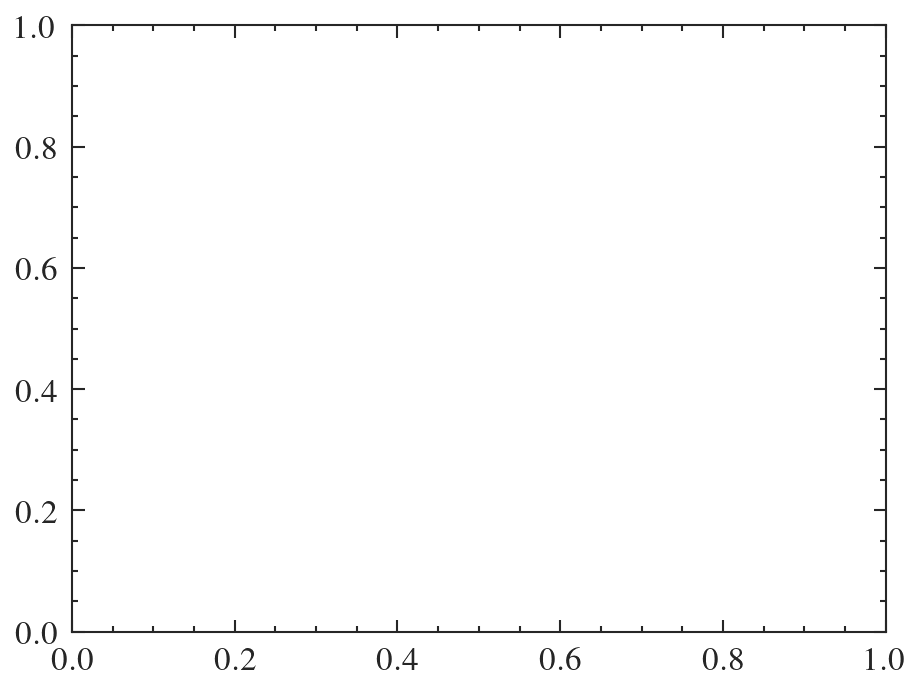

In [692]:
rw = results['reward_list'].reshape(4, -1)
kw = 1
for i in range(4):
    plt.plot(range(1000-kw+1), np.convolve(rw[i], np.ones(kw), mode='valid'),
                                      label=f"{results['names'][i]}", alpha=0.7) / kw
plt.legend(loc="lower right")
#plt.ylim((0, 3))
plt.show()

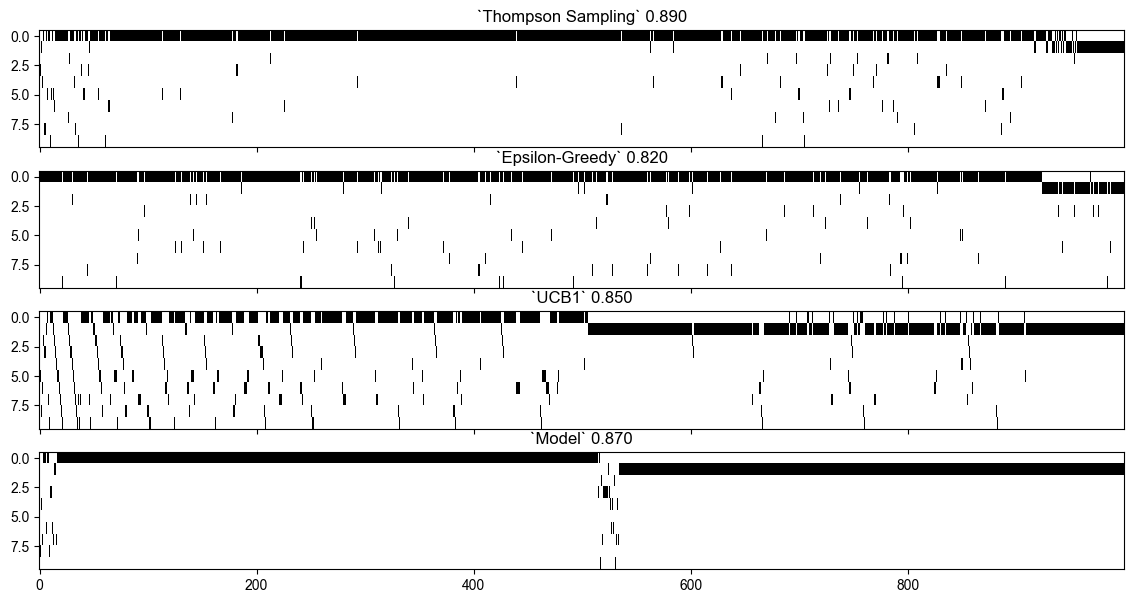

In [78]:
fig, axs = plt.subplots(4, 1, figsize=(14, 7), sharex=True)
for i, ax in enumerate(axs):
    ax.imshow(results['arm_list'][i].reshape(1000, 10).T, cmap="Greys", aspect="auto", interpolation="nearest")
    ax.set_title(f"{results['names'][i]} {results['scores'][i]:.3f}")

plt.show()

In [146]:
def calc_entropy(z):
    p = (z / z.sum())
    p = p[np.where(p != 0)[0]]
    return -(p * np.log(p)).sum()

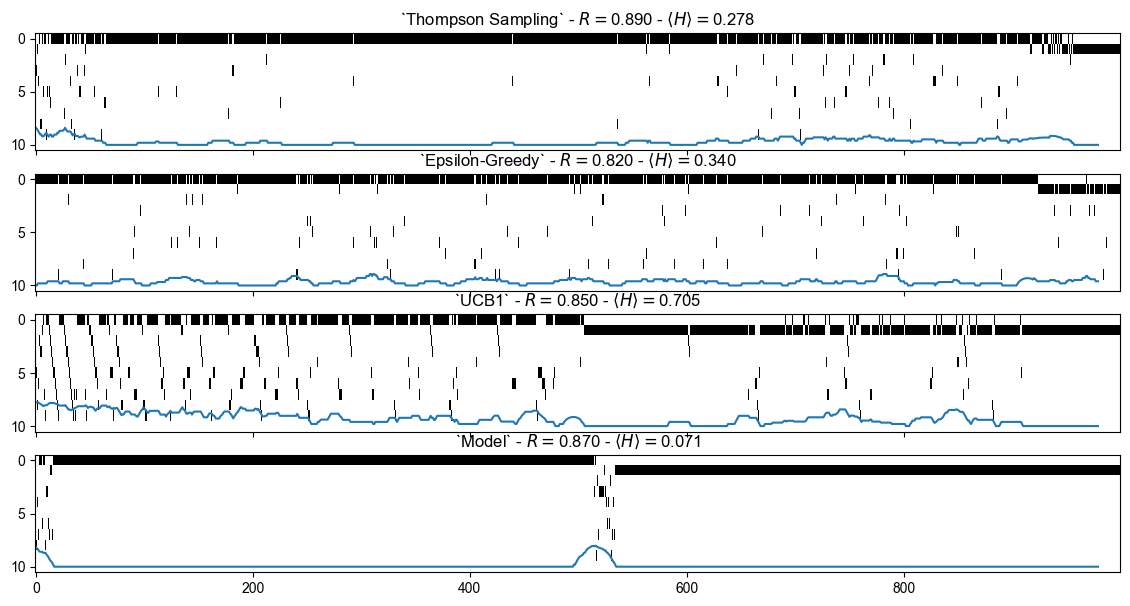

In [165]:
size = 20
fig, axs = plt.subplots(4, 1, figsize=(14, 7), sharex=True)
for i, ax in enumerate(axs):
    ax.imshow(results['arm_list'][i].reshape(1000, 10).T, cmap="Greys", aspect="auto", interpolation="nearest")

    arms = results['arm_list'][i].reshape(1000, 10)
    entropy = np.zeros(1000-size)
    for l in range(0, 1000-size):
        entropy[l] = calc_entropy(arms[l: l+size].sum(axis=0))
    ax.plot(range(1000-size), 10-entropy)
    ax.set_title(f"{results['names'][i]} - $R=${results['scores'][i]:.3f} - $\\langle H \\rangle=${entropy.mean():.3f}")

plt.show()

### run over many envs

In [7]:
settings1 = Settings()
settings1.rounds = 2000
settings1.trials = 2
settings1.reps = 15
settings1.verbose = True
settings1.K = 5
    
logger(f"reps:   {settings1.reps}")
logger(f"trials: {settings1.trials}")
logger(f"rounds: {settings1.rounds}")

all_results = {}

for env_name in ("v0", "driftv0", "driftv1", "sinv0"):
    
    settings1.env = env_name
    logger(f"env:    {settings1.env}")
    
    
    # parameters
    K = settings1.K
    nb_rounds = settings1.rounds
    nb_trials = settings1.trials
    nb_reps = settings1.reps
    verbose = settings1.verbose
    env_type = settings1.env
    
    # define proababilities set
    probabilities_set = []
    for i in range(nb_trials):
        p = np.around(np.random.uniform(0.05, 0.3, K), 2)
        p[i%K] = 0.9
        # p[np.random.randint(0, K)] = 0.9
        probabilities_set += [p.tolist()]
    
    probabilities_set = np.array(probabilities_set)
    
    # define the environment
    if env_type == "driftv0":
        env = envs.KABdriftv0(K=K,
                              probabilities_set=probabilities_set,
                              verbose=verbose,
                              tau=5)
    elif env_type == "driftv1":
        env = envs.KABdriftv1(K=K,
                              verbose=verbose,
                              tau=100,
                              normalize=True,
                              fixed_p=0.9)
    elif env_type == "sinv0":
        frequencies = np.linspace(0, 0.4, K)
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            normalize=True,
                            verbose=verbose)
    else:
        env = envs.KABv0(K=K,
                         probabilities_set=probabilities_set,
                         verbose=verbose)
    
    if verbose:
        logger.info(f"%env: {env}")
    
    # define models
    if settings1.load:
        # params = utils.load_model(idx=args.idx,
        #                           verbose=verbose)
    
        idx = settings1.idx if settings1.idx >= 0 else None
        params = utils.load_model(idx=idx)
        # params["K"] = K
        params["K"] = K
    
    else:
        params = {
            "K": K,
            "dur_pre": 2000,
            "dur_post": 2000,
            "lr": 0.1,
            "gain": 1.,
            "threshold": 0.5,
            "alpha": 0.,
            "beta": 1.,
            "mu": 0.,
            "sigma": 1.,
            "r": 1.,
            "alpha_lr": 0.1,
            "beta_lr": 0.1,
            "mu_lr": 0.1,
            "sigma_lr": 0.1,
            "r_lr": 0.1,
            "w_max": 5.,
            "value_function": "gaussian",
            "lr_function": "gaussian",
        }
    
    model_list = [
        mm.ThompsonSampling(K=K),
        mm.EpsilonGreedy(K=K, epsilon=0.1),
        mm.UCB1(K=K),
        mm.Model(**params)
    ]
    
    # run
    results = envs.trial_multiple_models(
                         models=model_list,
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         verbose=settings1.verbose)
    
    all_results[env_name] = results

logger()
logger("#done")

2024-11-26 19:06:52 | reps:   15
2024-11-26 19:06:52 | trials: 2
2024-11-26 19:06:52 | rounds: 2000
2024-11-26 19:06:52 | env:    v0
2024-11-26 19:06:52 | %env: KABv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:50<00:00, 91.38s/it]
2024-11-26 19:29:42 | env:    driftv0
2024-11-26 19:29:42 | %env: KABdriftv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:46<00:00, 91.12s/it]
2024-11-26 19:52:29 | env:    driftv1
2024-11-26 19:52:29 | %env: KABdriftv1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:46<00:00, 91.07s/it]
2024-11-26 20:15:15 | env:    sinv0
2024-11-26 20:15:15 | %env: KABsinv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22

In [9]:
all_results['v0'].keys()

dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'mean_scores', 'entropy_list', 'names'])

In [28]:
""" print score for all """

for (k, v) in all_results.items():

    print(f"[{k}]")
    print(f"\tmax:    {np.mean(v['upper_bound_list']):.3f}")
    print(f"\tchance: {np.mean(v['chance_list']):.3f}")

    for i, name in enumerate(v['names']):
        print(f"\t{name}:\t{v['scores'][i]:.3f} +/- {np.var(v['score_list'][i]):.5f}")

    print()

[v0]
	max:    0.900
	chance: 0.345
	`Thompson Sampling`:	0.901 +/- 0.00052
	`Epsilon-Greedy`:	0.537 +/- 0.09204
	`UCB1`:	0.895 +/- 0.00046
	`Model`:	0.904 +/- 0.00018

[driftv0]
	max:    0.870
	chance: 0.389
	`Thompson Sampling`:	0.759 +/- 0.01718
	`Epsilon-Greedy`:	0.688 +/- 0.01897
	`UCB1`:	0.773 +/- 0.01124
	`Model`:	0.771 +/- 0.00917

[driftv1]
	max:    0.629
	chance: 0.200
	`Thompson Sampling`:	0.553 +/- 0.04150
	`Epsilon-Greedy`:	0.334 +/- 0.06692
	`UCB1`:	0.585 +/- 0.03186
	`Model`:	0.633 +/- 0.01240

[sinv0]
	max:    0.200
	chance: 0.200
	`Thompson Sampling`:	0.189 +/- 0.00054
	`Epsilon-Greedy`:	0.203 +/- 0.00069
	`UCB1`:	0.205 +/- 0.00056
	`Model`:	0.208 +/- 0.00082



-------------------------
## **Simple**

In [315]:
""" settings """
settings1 = Settings()
settings1.rounds = 200
settings1.trials = 3
settings1.reps = 2
settings1.verbose = True
settings1.env = "simple"

In [11]:
""" run """
record = {}

Ks = [5, 10, 15]
for i, k in tqdm(zip(range(len(Ks)), Ks)):
    settings1.K = k
    results = main.main_multiple(args=settings1)
    record[str(i)] = results

print("done")

0it [00:00, ?it/s]2024-08-13 11:09:20 | %env: KArmedBandit(K=5, nb_sets=3)
2024-08-13 11:09:20 | Model info: {'date': '18/06/2024 at 23:11', 'model': 'Model', 'game': 'Env(10:700:1, K=10, env_type=smooth2)', 'evolved': ['tau_u', 'tau_v', 'gain', 'threshold', 'alpha', 'beta', 'mu', 'sigma', 'r', 'alpha_lr', 'beta_lr', 'mu_lr', 'sigma_lr', 'r_lr', 'w_max', 'lr', 'dur_pre', 'dur_post', 'lr_function'], 'data': 'k-armed bandit', 'other': 'all (2 Ks and 3 variants)', 'performance': {'gen': '73', 'fitness': '[0.65743]'}}
2024-08-13 11:09:20 | %names: ['`Thompson Sampling`', '`Epsilon-Greedy`', '`UCB1`', '`Model`']
2024-08-13 11:09:20 | %reps=2
2024-08-13 11:09:20 | %trials=3
2024-08-13 11:09:20 | %rounds=200
2024-08-13 11:09:20 | Model: `Thompson Sampling`
2024-08-13 11:09:20 | Model: `Epsilon-Greedy`
2024-08-13 11:09:20 | Model: `UCB1`
2024-08-13 11:09:20 | Model: `Model`
2024-08-13 11:09:20 | K-armed bandit: KArmedBandit(K=5, nb_sets=3)

  0%|                                                

done


In [12]:
record.keys()

dict_keys(['0', '1', '2'])

In [ ]:

record['0']['upper_bound_list'][0]

In [ ]:
record['0']['reward_list'][0].mean(axis=0).shape

ValueError: zero-size array to reduction operation minimum which has no identity

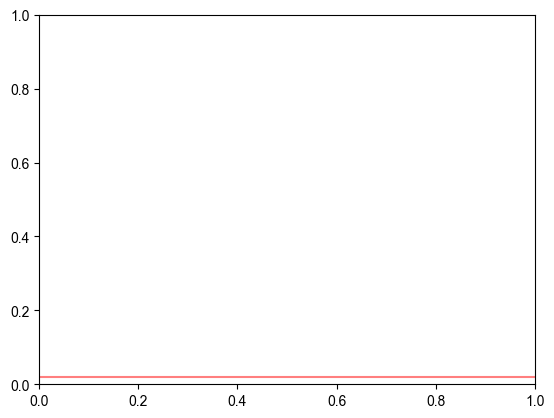

In [13]:

def plot(idx, color, m=2, theta=0.0125):

    # array of mean reward for each round over reps for a given trial
    z = record[f'{m}']['reward_list'][idx][:, 0].mean(axis=0)
    name = record['0']['names'][idx]

    # steady-state reward : last ~50
    mu_ref = z[-50:].mean()

    # residuals
    res = (z - mu_ref)**2

    # 1d convolution over y
    kc = 30
    y = convolve1d(res, np.ones(kc), mode="constant")/kc

    # point of stability
    cy_idx = np.where(y<theta)[0].min()
    plt.axvline(cy_idx, color=color, alpha=0.5, linestyle='-.',
                label=f"{cy_idx}")

    plt.plot(convolve1d(z, np.ones(kc), mode="constant")/kc,
             color=color,
             alpha=0.5, label=f"{name} residuals")
    plt.plot(y, alpha=0.5, linestyle='--', color=color,
             label=f"{name} rewards")

theta = 0.02
plt.axhline(y=theta, color='red', alpha=0.5)
plot(idx=1, color='grey', theta=theta)
plot(idx=2, color='blue', theta=theta)
plot(idx=3, color='green', theta=theta)
plt.legend(loc="lower right")
plt.show()

[0.14058667 0.14179    0.14499333 0.14819667 0.1514     0.15460333
 0.15780667 0.15901    0.16021333 0.16341667 0.16662    0.16982333
 0.17302667 0.17623    0.1981     0.1961     0.17743333 0.15676667
 0.15476667 0.15476667 0.15476667 0.17543333 0.17543333 0.15676667
 0.1381     0.1381     0.11943333 0.1381     0.15676667 0.17543333
 0.1941     0.21476667 0.21276667 0.21276667 0.23143333 0.23143333
 0.23143333 0.23343333 0.23543333 0.23543333 0.2541     0.2541
 0.2521     0.2521     0.2521     0.2541     0.2541     0.2561
 0.27676667 0.27676667 0.27676667 0.2581     0.27876667 0.27876667
 0.27876667 0.27676667 0.27676667 0.2581     0.23943333 0.22076667
 0.2021     0.18343333 0.18543333 0.18543333 0.16476667 0.16276667
 0.16076667 0.16076667 0.16076667 0.16076667 0.1421     0.16076667
 0.16276667 0.18143333 0.16276667 0.16276667 0.16276667 0.18143333
 0.16276667 0.16276667 0.16276667 0.16276667 0.1441     0.1441
 0.1441     0.1441     0.1441     0.1441     0.1441     0.1421
 0.16076667

NameError: name 'rounds' is not defined

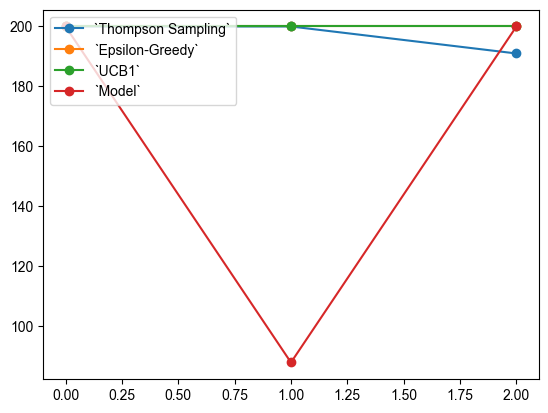

In [14]:
""" make the plot over different `K` """

def calc_stability_points(record, idx):

    points = []

    for _, k_record in record.items():

        # array of mean reward for each round over reps for a given trial
        z = k_record['reward_list'][idx][:, 0].mean(axis=0)
        name = k_record['names'][idx]

        # steady-state reward : last ~50
        mu_ref = z[-50:].mean()

        # residuals
        res = (z - mu_ref)**2

        # 1d convolution over y
        kc = 30
        y = convolve1d(res, np.ones(kc), mode="constant")/kc

        # point of stability
        print(y)
        p = np.where(y<0.02)[0]
        if len(p) < 2:
            points += [len(z)]
        else:
            points += [p.min()]

    return points, name


""" make plot """

colors = plt.cm.tab10(range(4))
for i in range(4):

    points, name = calc_stability_points(record, idx=i)

    print(f"{name}: {points}")

    plt.plot(points, '-o', color=colors[i], label=name)

# plt.yticks(np.arange(0, 1, 0.01), ())
plt.legend(loc="upper left")
plt.xticks(range(len(rounds)), rounds)
plt.grid()
plt.show()

-------------------------
## **Smooth**

In [ ]:
""" settings """
settings2 = Settings()
settings2.rounds = 1
settings2.trials = 300
settings2.reps = 2
settings2.K = 10
settings2.env = "smooth2"

In [ ]:
""" run """
record2 = {}

rounds = [1, 2]
for i, k in tqdm(zip(range(len(rounds)), rounds)):
    print(f"{i=} {k=}")
    settings2.rounds = k
    results2 = main.main_multiple(args=settings2)
    record2[str(i)] = results2

print("done")

In [ ]:
record2['0']['reward_list'].shape

In [ ]:
record2['0']['upper_bound_list'][:, 0].shape

In [ ]:
record2['0']['reward_list'][-1].mean(axis=0).mean(axis=1).shape

In [ ]:
z = record2['0']['reward_list'][-1].mean(axis=0).mean(axis=1)
mu_ref = z[-50:].mean()
res = (z - mu_ref)**2
y = convolve1d(res, np.ones(50), mode="constant")/50

kc = 100
yc = convolve1d(z, np.ones(kc), mode="constant")/kc
# plt.plot(y)
plt.plot(yc)

plt.show()

In [ ]:
def relu(x):
    return x*(x>0).astype(int)

In [ ]:

def calc_reg(record, ki, mi):
    z = record[f'{ki}']['reward_list'][mi].mean(axis=0).mean(axis=1)
    upper = record['0']['upper_bound_list'][0]
    res = relu(upper - z)
    return res.sum()


colors = plt.cm.tab10(range(4))
for i in range(4):
    res_m = []
    for ki in range(4):
        res_m += [calc_reg(record2, ki, i)]

    name = record2['0']['names'][i]
    plt.plot(res_m, '-o', color=colors[i], 
             label=name)

plt.legend(loc="upper left")
plt.xticks(range(4), rounds)
# plt.ylim(0, 200)
plt.show()

In [ ]:
z = record2[f'3']['reward_list'][1].mean(axis=0).mean(axis=1)
plt.plot(z)
plt.show()

In [ ]:
upper = record['0']['upper_bound_list'][0]
upper.shape

---
## Analysis

#### from saved runs

In [18]:
os.listdir('src/data')

['run_07122024_180644',
 'entropy_run_20241206-001613.json',
 'run_07122024_180743',
 'entropy_run_20241205-225936.json']

In [68]:
path = f"{os.getcwd()}/src/data/run_27112024_213424/{os.listdir('src/data/run_28112024_131920')[-1]}"
logger(path)
with open(path, "r") as f:
    data = json.load(f)

game_names = list(data.keys())
logger(game_names)

2024-11-29 14:30:30 | /Users/daniekru/Research/lab/minBandit/src/data/run_27112024_213424/large_run_results_K10.json
2024-11-29 14:30:30 | ['KABv0', 'KABdriftv0', 'KABdriftv1', 'KABsinv0']


In [69]:
data[game_names[0]].keys()

dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'names', 'entropy_list'])

In [165]:
""" print score for all """

#run_id = "run_02122024_112037"
#run_id = "run_30112024_231651"
run_id = "run_02122024_154742"

path = f"{os.getcwd()}/src/data/{run_id}/"

for run_path in os.listdir(f'src/data/{run_id}'):
    K = run_path.split(".")[0].split("K")[1]
    print(f"### {K=} " + "#"*50 + "\n")
    with open(f"{path}{run_path}", "r") as f:
        data = json.load(f)
    
    for (k, v) in data.items():
    
        print(f"[{k}]")
        print(f"\tmax:    {np.mean(v['upper_bound_list']):.3f}")
        print(f"\tchance: {np.mean(v['chance_list']):.3f}")
    
        for i, name in enumerate(v['names']):
            print(f"\t{name}:\t{v['scores'][i]:.3f} +/- {np.var(v['score_list'][i]):.5f}")
    
        print()

### K='100' ##################################################

[KABv0]
	max:    0.900
	chance: 0.187
	`Thompson Sampling`:	0.891 +/- 0.00039
	`Epsilon-Greedy`:	0.555 +/- 0.08121
	`UCB1`:	0.834 +/- 0.00765
	`Model`:	0.900 +/- 0.00053

[KABdriftv0]
	max:    0.883
	chance: 0.188
	`Thompson Sampling`:	0.627 +/- 0.01418
	`Epsilon-Greedy`:	0.576 +/- 0.01682
	`UCB1`:	0.554 +/- 0.00950
	`Model`:	0.650 +/- 0.02031

[KABsinv0]
	max:    0.020
	chance: 0.010
	`Thompson Sampling`:	0.015 +/- 0.00006
	`Epsilon-Greedy`:	0.020 +/- 0.00013
	`UCB1`:	0.014 +/- 0.00009
	`Model`:	0.010 +/- 0.00006

[KABsinv1]
	max:    0.682
	chance: 0.208
	`Thompson Sampling`:	0.669 +/- 0.00246
	`Epsilon-Greedy`:	0.619 +/- 0.00077
	`UCB1`:	0.611 +/- 0.00455
	`Model`:	0.662 +/- 0.00134



In [105]:
os.listdir(f'src/data/{run_id}')

['large_run_results_K100.json',
 'large_run_results_K5.json',
 'large_run_results_K10.json']

In [104]:
""" print score for all """

#run_id = "run_30112024_190927"
#run_id = "run_30112024_231651"
run_id = "run_02122024_112037"

path = f"{os.getcwd()}/src/data/{run_id}/"

for run_path in os.listdir(f'src/data/{run_id}'):
    K = run_path.split(".")[0].split("K")[1]
    print(f"### {K=} " + "#"*50 + "\n")
    with open(f"{path}{run_path}", "r") as f:
        data = json.load(f)
    
    for (k, v) in data.items():
    
        print(f"[{k}]")
        print(f"\tmax:    {np.mean(v['upper_bound_list']):.3f}")
        print(f"\tchance: {np.mean(v['chance_list']):.3f}")
    
        for i, name in enumerate(v['names']):
            print(f"\t{name}:\t{v['scores'][i]:.5f} +/- {np.var(v['score_list'][i]):.6f}")
    
        print()

### K='100' ##################################################

[KABv0]
	max:    0.900
	chance: 0.184
	`Thompson Sampling`:	0.89800 +/- 0.000208
	`Epsilon-Greedy`:	0.62567 +/- 0.095860
	`UCB1`:	0.85583 +/- 0.010917
	`Model`:	0.90100 +/- 0.000582

[KABdriftv0]
	max:    0.881
	chance: 0.181
	`Thompson Sampling`:	0.61417 +/- 0.014815
	`Epsilon-Greedy`:	0.49567 +/- 0.024920
	`UCB1`:	0.57650 +/- 0.010365
	`Model`:	0.61517 +/- 0.024371

[KABsinv0]
	max:    0.020
	chance: 0.010
	`Thompson Sampling`:	0.01067 +/- 0.000060
	`Epsilon-Greedy`:	0.01567 +/- 0.000076
	`UCB1`:	0.00933 +/- 0.000071
	`Model`:	0.00783 +/- 0.000043

[KABsinv1]
	max:    0.673
	chance: 0.212
	`Thompson Sampling`:	0.66000 +/- 0.001372
	`Epsilon-Greedy`:	0.63183 +/- 0.001236
	`UCB1`:	0.59500 +/- 0.004763
	`Model`:	0.64617 +/- 0.002351

### K='5' ##################################################

[KABv0]
	max:    0.900
	chance: 0.298
	`Thompson Sampling`:	0.76117 +/- 0.046116
	`Epsilon-Greedy`:	0.55633 +/- 0.088007
	`UCB1`:	0

In [87]:
env_names = tuple(data.keys())
env_names

('KABv0', 'KABdriftv0', 'KABdriftv1', 'KABsinv0')

---

In [128]:
big_data = {}
#run_list = ("run_30112024_190927", "run_30112024_231651") # previous
run_list = ("run_02122024_112037", None)

for run_id in run_list:
    if run_id is None:
        continue

    path = f"{os.getcwd()}/src/data/{run_id}/"

    logger(f"loading {run_id}...")
    run_path_list = os.listdir(f'src/data/{run_id}')
    sorted(run_path_list)
    for run_path in tqdm(os.listdir(f'src/data/{run_id}')):
        K = run_path.split(".")[0].split("K")[1]
        with open(f"{path}{run_path}", "r") as f:
            data = json.load(f)

        big_data[int(K)] = data

    del data

keys = list(big_data.keys())
keys.sort()
big_data = {i: big_data[i] for i in keys}

2024-12-02 14:12:16 | loading run_02122024_112037...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.65s/it]


In [129]:
big_data.keys()

dict_keys([5, 10, 100])

In [130]:
games = {}
for k, run in big_data.items():
    for e, data in run.items():
        if e not in games.keys():
            games[e] = {"mean": [], "std": [], "max": [], "min": []}
            
        games[e]["mean"] += [data["scores"]]
        games[e]["std"] += [np.array(data["score_list"]).std(axis=1).mean(axis=1).tolist()]
        games[e]["max"] += [np.mean(data["upper_bound_list"])]
        games[e]["min"] += [np.mean(data["chance_list"])]

logger(games.keys())

k_names = tuple(big_data.keys())
logger(k_names)
mod_names = big_data[5]["KABv0"]['names']
logger(mod_names)
env_names = ("KAB-0", "KAB-$\\epsilon$", "KAB-$\\sin$v0", "KAB-$\\sin$v1")
logger(env_names)

2024-12-02 14:12:35 | dict_keys(['KABv0', 'KABdriftv0', 'KABsinv0', 'KABsinv1'])
2024-12-02 14:12:35 | (5, 10, 100)
2024-12-02 14:12:35 | ['`Thompson Sampling`', '`Epsilon-Greedy`', '`UCB1`', '`Model`']
2024-12-02 14:12:35 | ('KAB-0', 'KAB-$\\epsilon$', 'KAB-$\\sin$v0', 'KAB-$\\sin$v1')


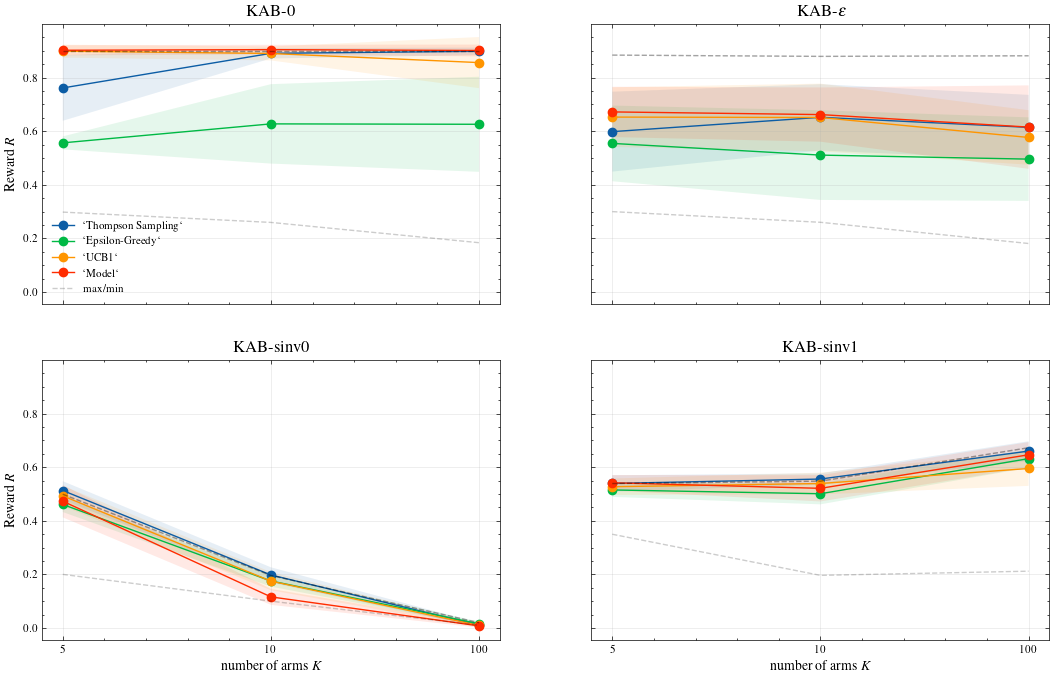

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(13, 8), sharex=True, sharey=True)
axs = axs.flatten()
for j, (ax, (k, v)) in enumerate(zip(axs, games.items())):

    m = np.array(v['mean'])
    s = np.array(v['std'])
    for i in range(4):
        if j == 0:
            ax.plot(range(len(k_names)), m[:, i], '-o', label=f"{mod_names[i]}")
        else:
            ax.plot(range(len(k_names)), m[:, i], '-o', label=f"{mod_names[i]}")
        ax.fill_between(range(len(k_names)),
                     m[:, i] - s[:, i],
                     m[:, i] + s[:, i],
                     alpha=0.1)

    ax.plot(v['max'], color="black", alpha=0.2, linestyle="--")
    ax.plot(v['min'], color="black", alpha=0.2, linestyle="--")
    ax.set_title(f"{env_names[j]}")
    ax.set_xticks(range(len(k_names)))
    ax.set_xticklabels(k_names)

    if j % 2 == 0:
        ax.set_ylabel("Reward $R$")
    if j > 1:
        ax.set_xlabel("number of arms $K$")

    ax.grid(alpha=0.3)
    if j == 0:
        ax.plot(v['max'], color="black", alpha=0.2, linestyle="--", label="max/min")
        ax.legend(loc="lower left")
    else:
        ax.plot(v['max'], color="black", alpha=0.2, linestyle="--")

plt.show()


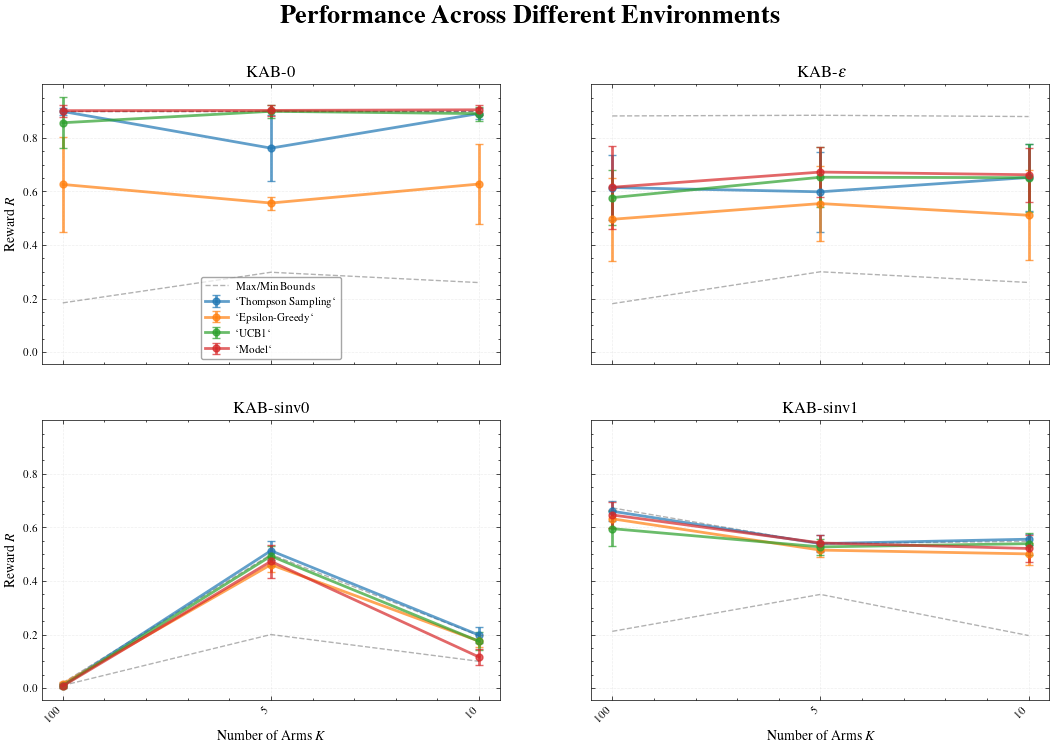

In [115]:
# Set the style and font for a professional, publication-ready look
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Create figure with improved layout
fig, axs = plt.subplots(2, 2, figsize=(13, 8), 
                        sharex=True, sharey=True, 
                        constrained_layout=False)
axs = axs.flatten()

# Color palette - colorblind-friendly
colors = sns.color_palette("tab10", 4)

for j, (ax, (k, v)) in enumerate(zip(axs, games.items())):
    m = np.array(v['mean'])
    s = np.array(v['std'])
    
    for i in range(4):
        # Plot mean with error bands
        ax.errorbar(range(len(k_names)), m[:, i], 
                    yerr=s[:, i], 
                    fmt='-o', 
                    color=colors[i],
                    capsize=3,
                    label=f"{mod_names[i]}",
                    alpha=0.7,
                    linewidth=2,
                    markersize=5)
    
    # Max and min lines
    ax.plot(v['max'], color="black", alpha=0.3, linestyle="--", linewidth=1)
    ax.plot(v['min'], color="black", alpha=0.3, linestyle="--", linewidth=1)
    
    # Formatting
    ax.set_title(f"{env_names[j]}", fontweight='bold')
    ax.set_xticks(range(len(k_names)))
    ax.set_xticklabels(k_names, rotation=45, ha='right')
    
    # Y-axis label only for leftmost plots
    if j % 2 == 0:
        ax.set_ylabel(r"Reward $R$")
    
    # X-axis label only for bottom plots
    if j > 1:
        ax.set_xlabel(r"Number of Arms $K$")
    
    ax.grid(alpha=0.2, linestyle='--')
    
    # Legend only for the first subplot
    if j == 0:
        ax.plot(v['max'], color="black", alpha=0.3, linestyle="--", 
                label="Max/Min Bounds", linewidth=1)
        ax.legend(loc="best", frameon=True, 
                  fancybox=True, 
                  framealpha=0.7, 
                  edgecolor='gray')

# Adjust overall figure appearance
fig.suptitle(r'\textbf{Performance Across Different Environments}', 
             fontsize=19, y=0.98)

# Save with high DPI for publication
#plt.savefig('minBandit/paper/figures/performance_plot.png',  dpi=500, bbox_inches='tight')
plt.show()

---
#### from saved run II

In [24]:
""" list available runs """
path_ = r'src/tmp'
#data_list = os.listdir('pigeon/data')
#data_list = os.listdir('minBandit/src/data')
data_list = os.listdir(path_)


[f"{i}: {dl}" for i, dl in enumerate(data_list)]

['0: run_12122024_005306']

In [25]:
#indexes = (1, 4, 8)
indexes = [0]
env_names = ("KAB-0", "KAB-$\\epsilon$", "KAB-$\\sin$v0", "KAB-$\\sin$v1")
mod_names = ['Thompson Sampling', 'Epsilon-Greedy', 'UCB1', 'Model']

""" loop over the saved and selected datasets """
all_contents = []
k_names = []
for idx in indexes:

    logger(f"parsing dataset {idx}")

    """ pick and load dateset """
    #path_to_file = f"pigeon/data/{data_list[idx]}/"
    path_to_file = f"{path_}/{data_list[idx]}/"
    file = os.listdir(path_to_file)[0]
    
    with open(f"{path_to_file}/{file}", "r") as f:
        data = json.load(f)
        
    k_names += list(data['0'].keys())
        
    """ parse dataset """
    num_ks = len(data['0'].keys())
    num_reps = len(data.keys())
    content = {key: {"scores": np.zeros((num_ks, num_reps, 4)),
                     "max": np.zeros((num_ks, num_reps, 1)),
                     "chance": np.zeros((num_ks, num_reps, 1))} for key in data['0'][k_names[-1]]}
    
    for ir, rep in tqdm(data.items()):
        for ik, (_, k_run) in enumerate(rep.items()):  
            for game_name, values in k_run.items():
                content[game_name]["scores"][ik, int(ir)] = values["score"]
                content[game_name]["max"][ik, int(ir)] = values["max"]
                content[game_name]["chance"][ik, int(ir)] = values["chance"]
    
    """ compute mean and std """
    for game_name in content:
        scores = content[game_name]["scores"]
        stats = {
            "means": scores.mean(axis=1),
            "std": scores.std(axis=1),
            "max": content[game_name]["max"].mean(axis=1),
            "chance": content[game_name]["chance"].mean(axis=1),
        }
        content[game_name]["stats"] = stats    
    #
    all_contents += [content]

""" merge datasets """
logger("merging datasets..")
ref_content = all_contents[0]
for content in all_contents[1:]:
    for env_, data_ in content.items():
        ref_content[env_]['stats']['means'] = np.vstack((ref_content[env_]['stats']['means'],
                                                        data_['stats']['means']))
        ref_content[env_]['stats']['std'] = np.vstack((ref_content[env_]['stats']['std'],
                                                        data_['stats']['std']))
        ref_content[env_]['stats']['max'] = np.vstack((ref_content[env_]['stats']['max'],
                                                        data_['stats']['max']))
        ref_content[env_]['stats']['chance'] = np.vstack((ref_content[env_]['stats']['chance'],
                                                        data_['stats']['chance']))
content = ref_content
logger("[done]")

2024-12-12 00:54:57 | parsing dataset 0
100%|██████████████████████████████████| 5/5 [00:00<00:00, 38479.85it/s]
2024-12-12 00:54:57 | merging datasets..
2024-12-12 00:54:57 | [done]


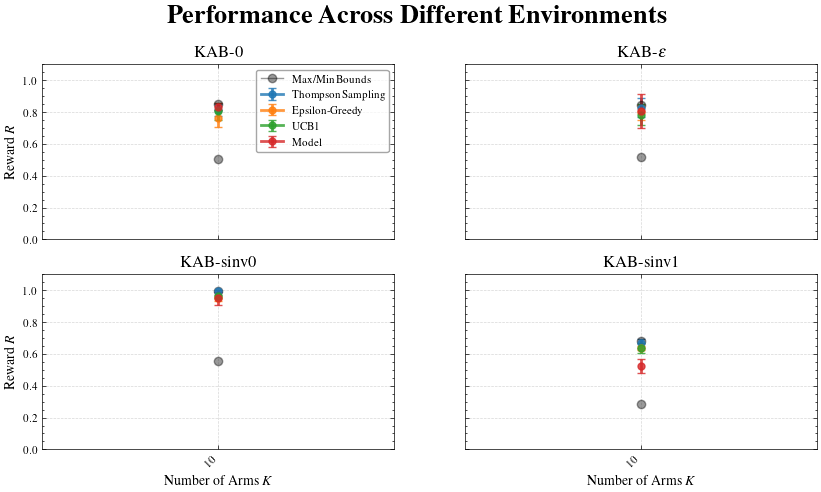

In [27]:
""" plot """
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Create figure with improved layout
fig, axs = plt.subplots(2, 2, figsize=(10, 5), 
                        sharex=True, sharey=True, 
                        constrained_layout=False)
axs = axs.flatten()

# Color palette - colorblind-friendly
colors = sns.color_palette("tab10", 4)

for j, (ax, game_name) in enumerate(zip(axs, content)):
    
    m = content[game_name]['stats']['means']
    s = content[game_name]['stats']['std']
    upper = content[game_name]['stats']['max']
    lower = content[game_name]['stats']['chance']
    
    for i in range(4):
        # Plot mean with error bands
        ax.errorbar(range(len(k_names)), 
                    m[:, i], 
                    yerr=s[:, i], 
                    fmt='-o', 
                    color=colors[i],
                    capsize=3,
                    label=f"{mod_names[i]}",
                    alpha=0.8,
                    linewidth=2,
                    markersize=5)
    
    # Formatting
    ax.set_title(f"{env_names[j]}", fontweight='bold')
    ax.set_xticks(range(len(k_names)))
    ax.set_xticklabels(k_names, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    
    # Y-axis label only for leftmost plots
    if j % 2 == 0:
        ax.set_ylabel(r"Reward $R$")
    
    # X-axis label only for bottom plots
    if j > 1:
        ax.set_xlabel(r"Number of Arms $K$")
    
    ax.grid(alpha=0.5, linestyle='--')
    
    # Legend only for the first subplot
    if j == 0:
        ax.plot(upper, '-o', color="black", alpha=0.4, 
                label="Max/Min Bounds", linewidth=1)
        ax.plot(lower, "-o", color="black", alpha=0.4, linewidth=1)
        
        ax.legend(loc="best", frameon=True, 
                  fancybox=True, 
                  framealpha=0.7, 
                  edgecolor='gray')
    else:
        # Max and min lines
        ax.plot(upper, "-o", color="black", alpha=0.4, linewidth=1)
        ax.plot(lower, "-o", color="black", alpha=0.4, linewidth=1)

# Adjust overall figure appearance
fig.suptitle(r'\textbf{Performance Across Different Environments}', 
             fontsize=19, y=1.)

# Save with high DPI for publication
#plt.savefig(r'minBandit/paper/figures/performance_plot.png',  dpi=500, bbox_inches='tight')
plt.show()

In [410]:
os.listdir()

['paper',
 'evo_main.py',
 '.DS_Store',
 '.pytest_cache',
 'bin',
 '__pycache__',
 'README.md',
 'configs',
 '.git',
 'main.py',
 'notebooks',
 'media',
 'src']

---
#### model entropy

In [113]:
os.listdir('src/data/run_28112024_131920')[0]

'large_run_results_K200.json'

In [168]:
run_path

['large_run_results_K100.json']

In [ ]:
#run_id = "run_02122024_112037"
run_id = "run_02122024_154742"
run_path = os.listdir(f'src/data/{run_id}')[0]

K = int(run_path.split(".")[0].split("K")[1])
print(f"### {K=} " + "#"*50 + "\n")
with open(f"{path}{run_path}", "r") as f:
    data = json.load(f)


[KABv0]


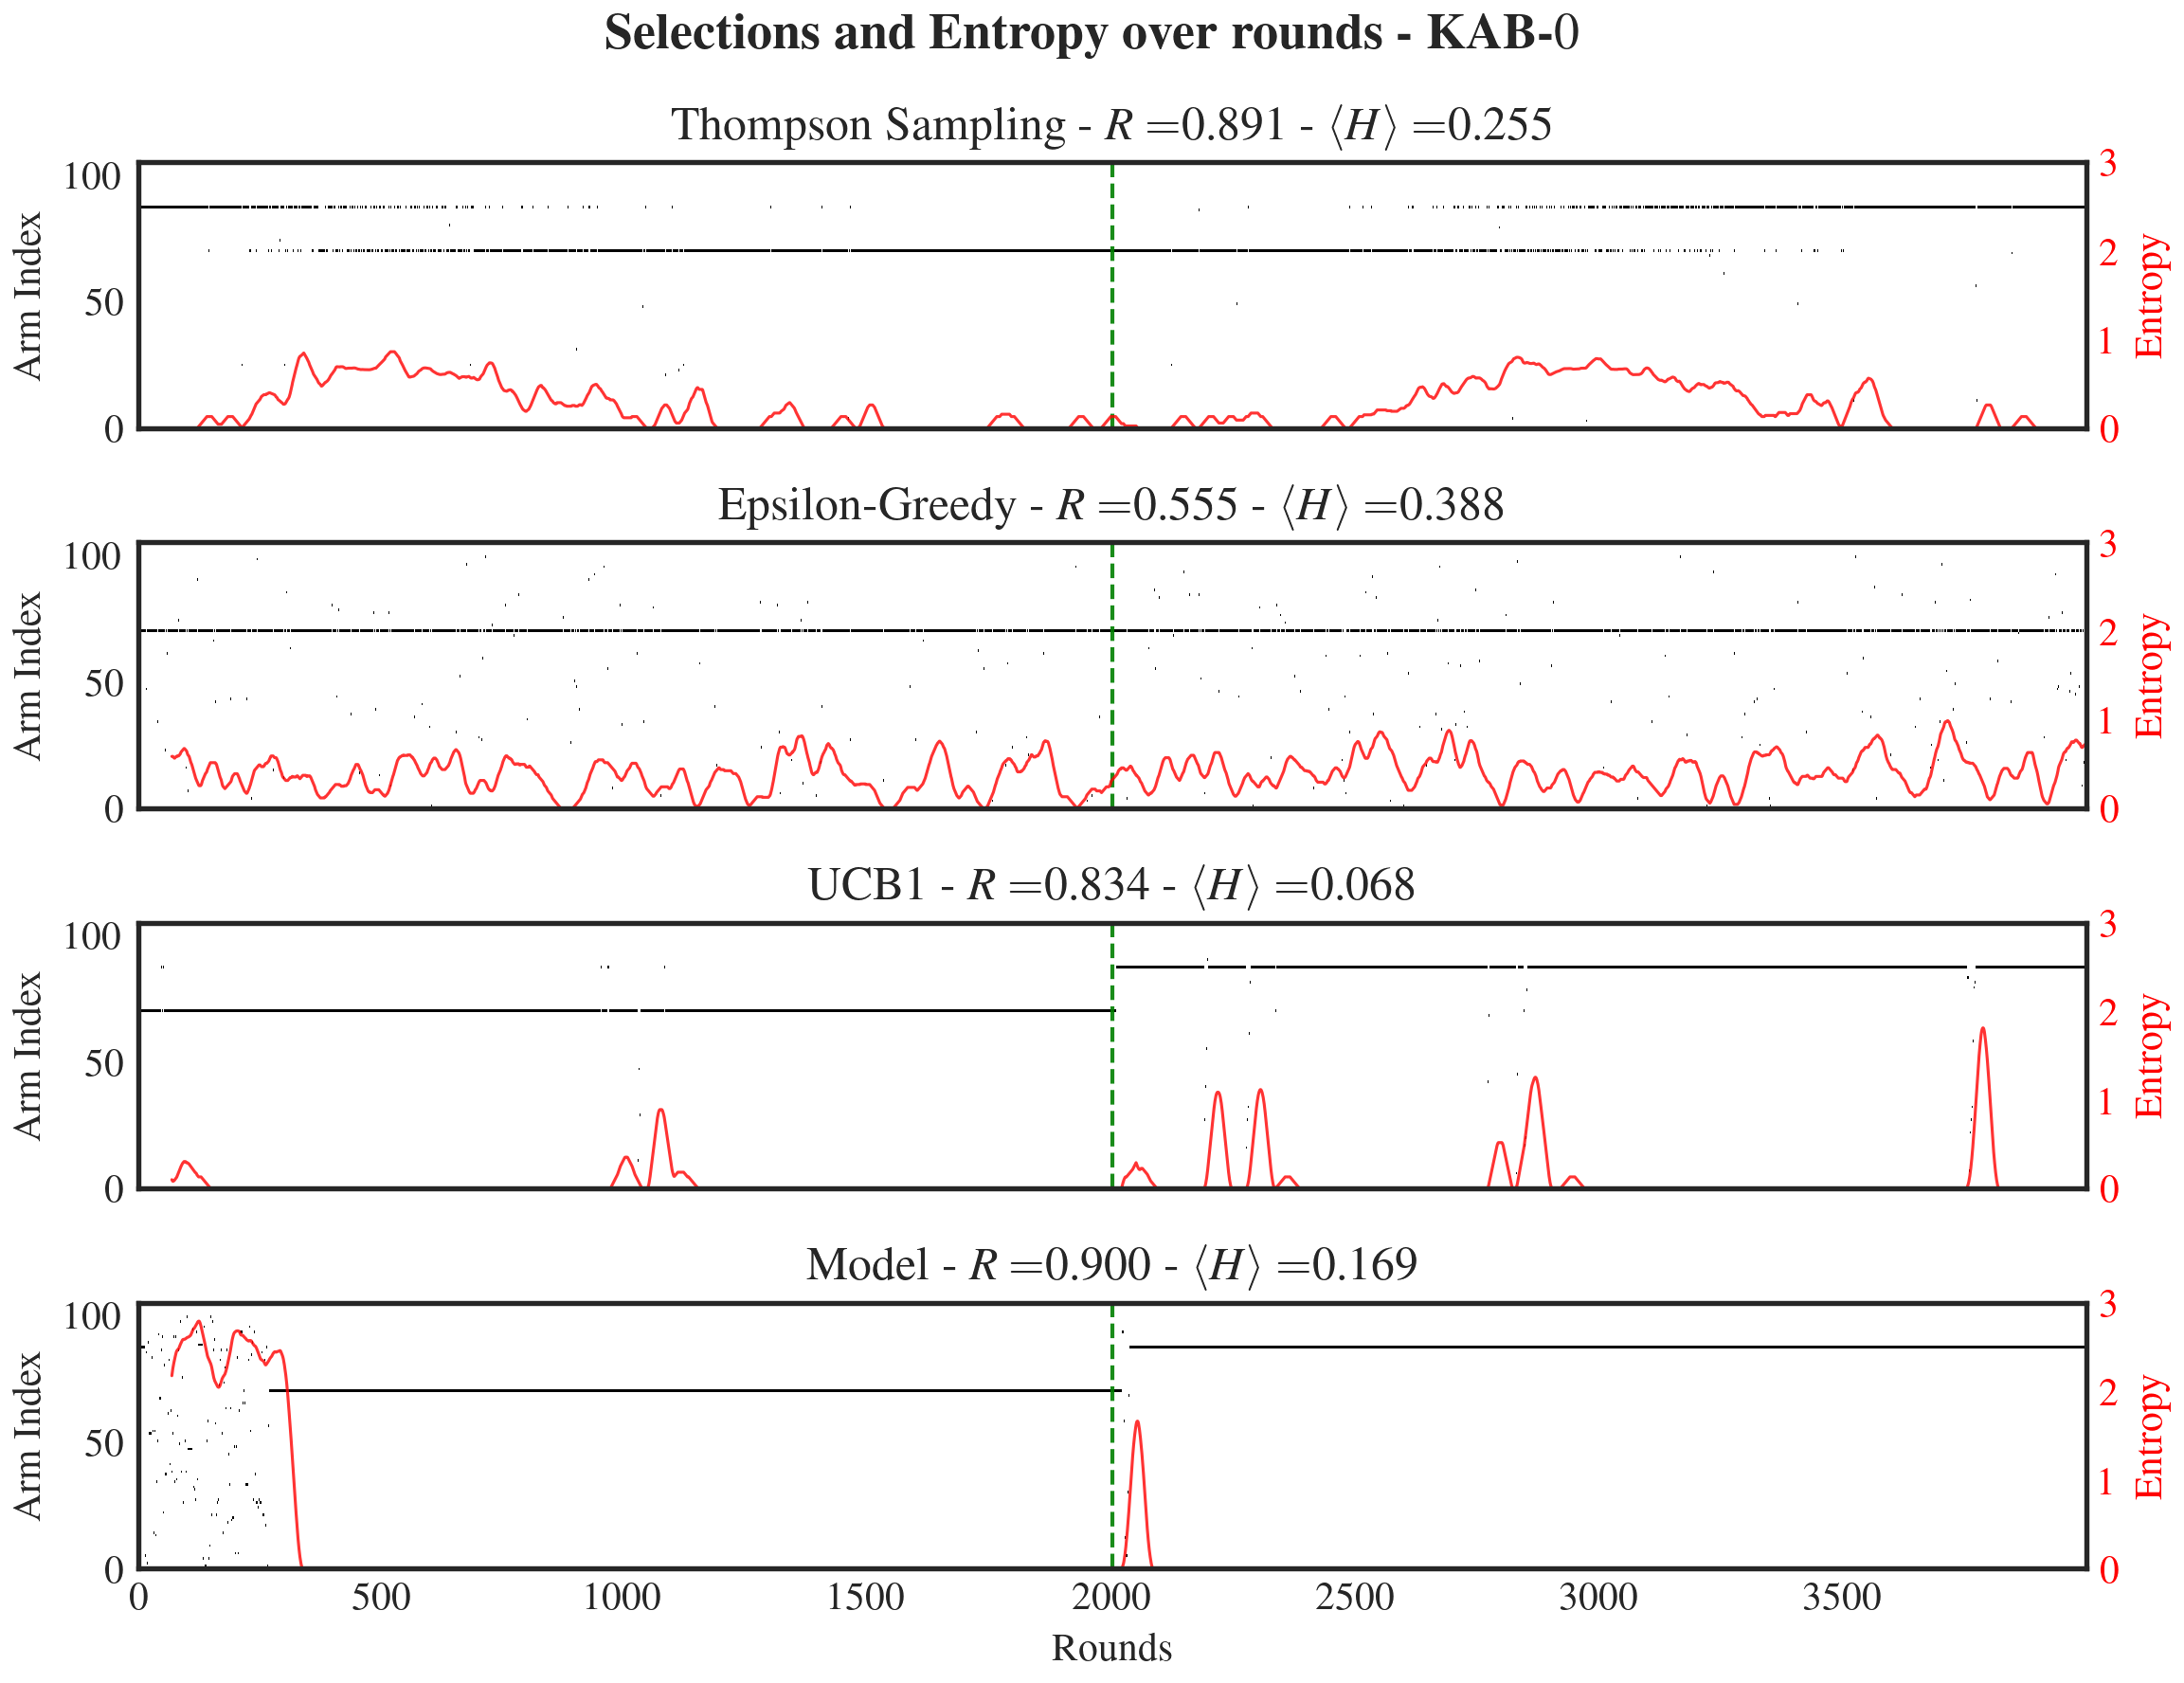

In [187]:
def create_publication_figure(data):
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times', 'Computer Modern Roman'],
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'figure.dpi': 300,
    })

    size = 20
    shape = np.array(data[list(data.keys())[0]]['arm_list']).shape
    trials = shape[2]
    rounds = shape[3]
    rep_i = 9

    for (k, v) in data.items():
        print(f"[{k}]")
        
        fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
        fig.tight_layout(pad=3.0, h_pad=2.0)
        
        twin_axs = [ax.twinx() for ax in axs]
        
        for i, (ax, twin_ax) in enumerate(zip(axs, twin_axs)):
            # Heatmap plot
            heatmap_data = np.array(v['arm_list'][i][rep_i]).reshape(rounds*trials, K).T
            #heatmap_data = np.array(v['arm_list'][i]).mean(axis=0).reshape(rounds*trials, K).T
            im = ax.imshow(heatmap_data, cmap="Greys", aspect="auto", interpolation="nearest", vmin=0, vmax=1)
            
            # Add vertical lines for trial boundaries
            for t in range(0, trials):
                ax.axvline(x=t*rounds, color='green', linestyle='--', alpha=0.9)
            
            # Entropy plot on secondary y-axis
            entropy = np.array(v['entropy_list'][i][rep_i]).reshape(-1)
            #entropy = np.array(v['entropy_list'][i]).mean(axis=0).reshape(-1)

            size_ety = 30
            entropy = np.convolve(entropy, np.ones(size_ety), mode="valid")/size_ety
            entropy_line = twin_ax.plot(range(trials*size+size_ety-1, rounds*trials), entropy, alpha=0.8, 
                                        color='red', lw=0.75, label='Entropy')
            
            # Formatting primary axis (heatmap)
            ax.set_ylim((0, K+5))
            ax.set_ylabel('Arm Index')
            
            # Formatting secondary axis (entropy)
            twin_ax.set_ylabel('Entropy', color='red')
            twin_ax.set_ylim((0, 3))
            twin_ax.tick_params(axis='y', labelcolor='red')
            
            # Title with performance metrics
            ax.set_title(f"{v['names'][i][1:-1]} - $R=${v['scores'][i]:.3f} - $\\langle H \\rangle=${entropy.mean():.3f}")
        
        # X-axis label for the bottom subplot
        axs[-1].set_xlabel('Rounds')
        
        # Adjust layout and add a overall title
        plt.suptitle(r'\textbf{Selections and Entropy over rounds - KAB-$0$}', fontsize=13, y=1.01)
        
        #plt.savefig(f'selections_entropy_{k}.png', bbox_inches='tight', dpi=500)
        
        plt.show()

        break

# Note: Make sure to define these variables before calling the function
# rounds, trials, size, K, rep_i should be defined from your original context
create_publication_figure(data)

In [583]:
def plot_c(data, settings, save=False):
    
    k, v = settings.env, data
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times', 'Computer Modern Roman'],
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'figure.dpi': 300,
    })

    size = 20
    trials = settings.trials
    rounds = settings.rounds
    rep_i = 0
    K = settings.K

    print(f"[{k}]")
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    fig.tight_layout(pad=3.0, h_pad=2.0)
    
    twin_axs = [ax.twinx() for ax in axs]
    
    for i, (ax, twin_ax) in enumerate(zip(axs, twin_axs)):
        # Heatmap plot
        heatmap_data = np.array(v['arm_list'][i]).reshape(rounds*trials, K).T
        im = ax.imshow(heatmap_data, cmap="Greys", aspect="auto", interpolation="nearest", vmin=0, vmax=1)
        
        # Add vertical lines for trial boundaries
        for t in range(0, trials):
            ax.axvline(x=t*rounds, color='green', linestyle='--', alpha=0.9)
        
        # Entropy plot on secondary y-axis
        entropy = np.array(v['entropy_list'][i]).reshape(-1)
        entropy = np.convolve(entropy, np.ones(size), mode="valid") / size
        entropy_line = twin_ax.plot(range(trials*size, rounds*trials), entropy, alpha=0.7, 
                                    color='red', lw=0.3, label='Entropy')
        
        # Formatting primary axis (heatmap)
        ax.set_ylim((-5, K+5))
        ax.set_ylabel('Arm Index')
        
        # Formatting secondary axis (entropy)
        twin_ax.set_ylabel('Entropy', color='red')
        twin_ax.tick_params(axis='y', labelcolor='red')
        
        # Title with performance metrics
        ax.set_title(f"{v['names'][i][1:-1]} - $R=${v['scores'][i]:.3f} - $\\langle H \\rangle=${entropy.mean():.3f}")
        
        # X-axis label for the bottom subplot
        axs[-1].set_xlabel('Rounds')
        
        # Adjust layout and add a overall title
        plt.suptitle(f'Performance Analysis - {k}', fontsize=16, y=1.02)

        if save:
            plt.savefig(f'performance_analysis_{k}.png', 
                    bbox_inches='tight', 
                    dpi=500)
            print("saved")
        
    plt.show()



In [63]:
sweep_params = {
"alpha":0.4450195718988339,
"alpha_lr":-2.958221399416473,
"beta":7.391580370882872,
"beta_lr":0.9526338245859882,
"gain":47.86910588825282,
"lr":0.2773642826170334,
"mu":2.6713225228884383,
"mu_lr":-0.6084876849578418,
"r":0.5161936304182647,
"r_lr":0.044296190220556864,
"sigma":0.5450255193262612,
"sigma_lr":4.463404997440599,
"threshold":0.3842711049268154,
"w_max":2.461390370832377,
"K": None,
"dur_pre": 2000,
"dur_post": 2000,
"value_function": "gaussian",
"lr_function": "gaussian",}

In [56]:
params

{'alpha': 0.4450195718988339,
 'alpha_lr': -2.958221399416473,
 'beta': 7.391580370882872,
 'beta_lr': 0.9526338245859882,
 'gain': 47.86910588825282,
 'lr': 0.2773642826170334,
 'mu': 2.6713225228884383,
 'mu_lr': -0.6084876849578418,
 'r': 0.5161936304182647,
 'r_lr': 0.044296190220556864,
 'sigma': 0.5450255193262612,
 'sigma_lr': 4.463404997440599,
 'threshold': 0.3842711049268154,
 'w_max': 2.461390370832377}

In [124]:
sweep_params = utils.load_model(idx=4) # 1

In [58]:
model_list[-1].

Model(K=10, dur_pre=2516, dur_post=2322)

In [380]:
settings1 = Settings()
settings1.rounds = 2000
settings1.trials = 3
settings1.reps = 1
settings1.verbose = True
settings1.idx = 6
settings1.env = "v0"
settings1.K = 50

logger(f"reps:   {settings1.reps}")
logger(f"trials: {settings1.trials}")
logger(f"rounds: {settings1.rounds}")
logger(f"env:    {settings1.env}")
#logger(f"argmax: {probabilities_set.argmax(axis=1)}")


# define proababilities set
probabilities_set = []
for i in range(settings1.trials):
    p = np.around(np.random.uniform(0.05, 0.5, settings1.K), 2)
    p[np.random.randint(0, settings1.K)] = 0.9
    #p[i%K] = 0.9
    # p[np.random.randint(0, K)] = 0.9
    probabilities_set += [p.tolist()]

probabilities_set = np.array(probabilities_set)

def run_(settings, probabilities_set):
    
    # parameters
    K = settings1.K
    nb_rounds = settings1.rounds
    nb_trials = settings1.trials
    nb_reps = settings1.reps
    verbose = settings1.verbose
    env_type = settings1.env
    
    
    # define the environment
    if env_type == "driftv0":
        env = envs.KABdriftv0(K=K,
                              probabilities_set=probabilities_set,
                              verbose=verbose,
                              tau=5)
    elif env_type == "driftv1":
        env = envs.KABdriftv1(K=K,
                              verbose=verbose,
                              tau=100,
                              normalize=True,
                              fixed_p=0.9)
    elif env_type == "sinv0":
        frequencies = np.linspace(0, 0.4, K)
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            normalize=True,
                            verbose=verbose)
    else:
        env = envs.KABv0(K=K,
                         probabilities_set=probabilities_set,
                         verbose=verbose)
    
    if verbose:
        logger.info(f"%env: {env}")
    
    # define models
    params = utils.load_model(idx=settings1.idx)
    params["K"] = K
    
    
    model_list = [
        mm.ThompsonSampling(K=K),
        mm.EpsilonGreedy(K=K, epsilon=0.1),
        mm.UCB1(K=K),
        mm.Model(**params)
    ]
    
    # run
    results = envs.trial_multiple_models(
                         models=model_list,
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         entropy_calc=True,
                         verbose=settings1.verbose)
    return results

results_entr = run_(settings1, probabilities_set)

#plot_c(data=results, settings=settings1)

2024-12-08 02:47:06 | reps:   1
2024-12-08 02:47:06 | trials: 3
2024-12-08 02:47:06 | rounds: 2000
2024-12-08 02:47:06 | env:    v0
2024-12-08 02:47:06 | %env: KABv0
100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:45<00:00, 55.10s/it]


[v0]
saved
saved
saved
saved


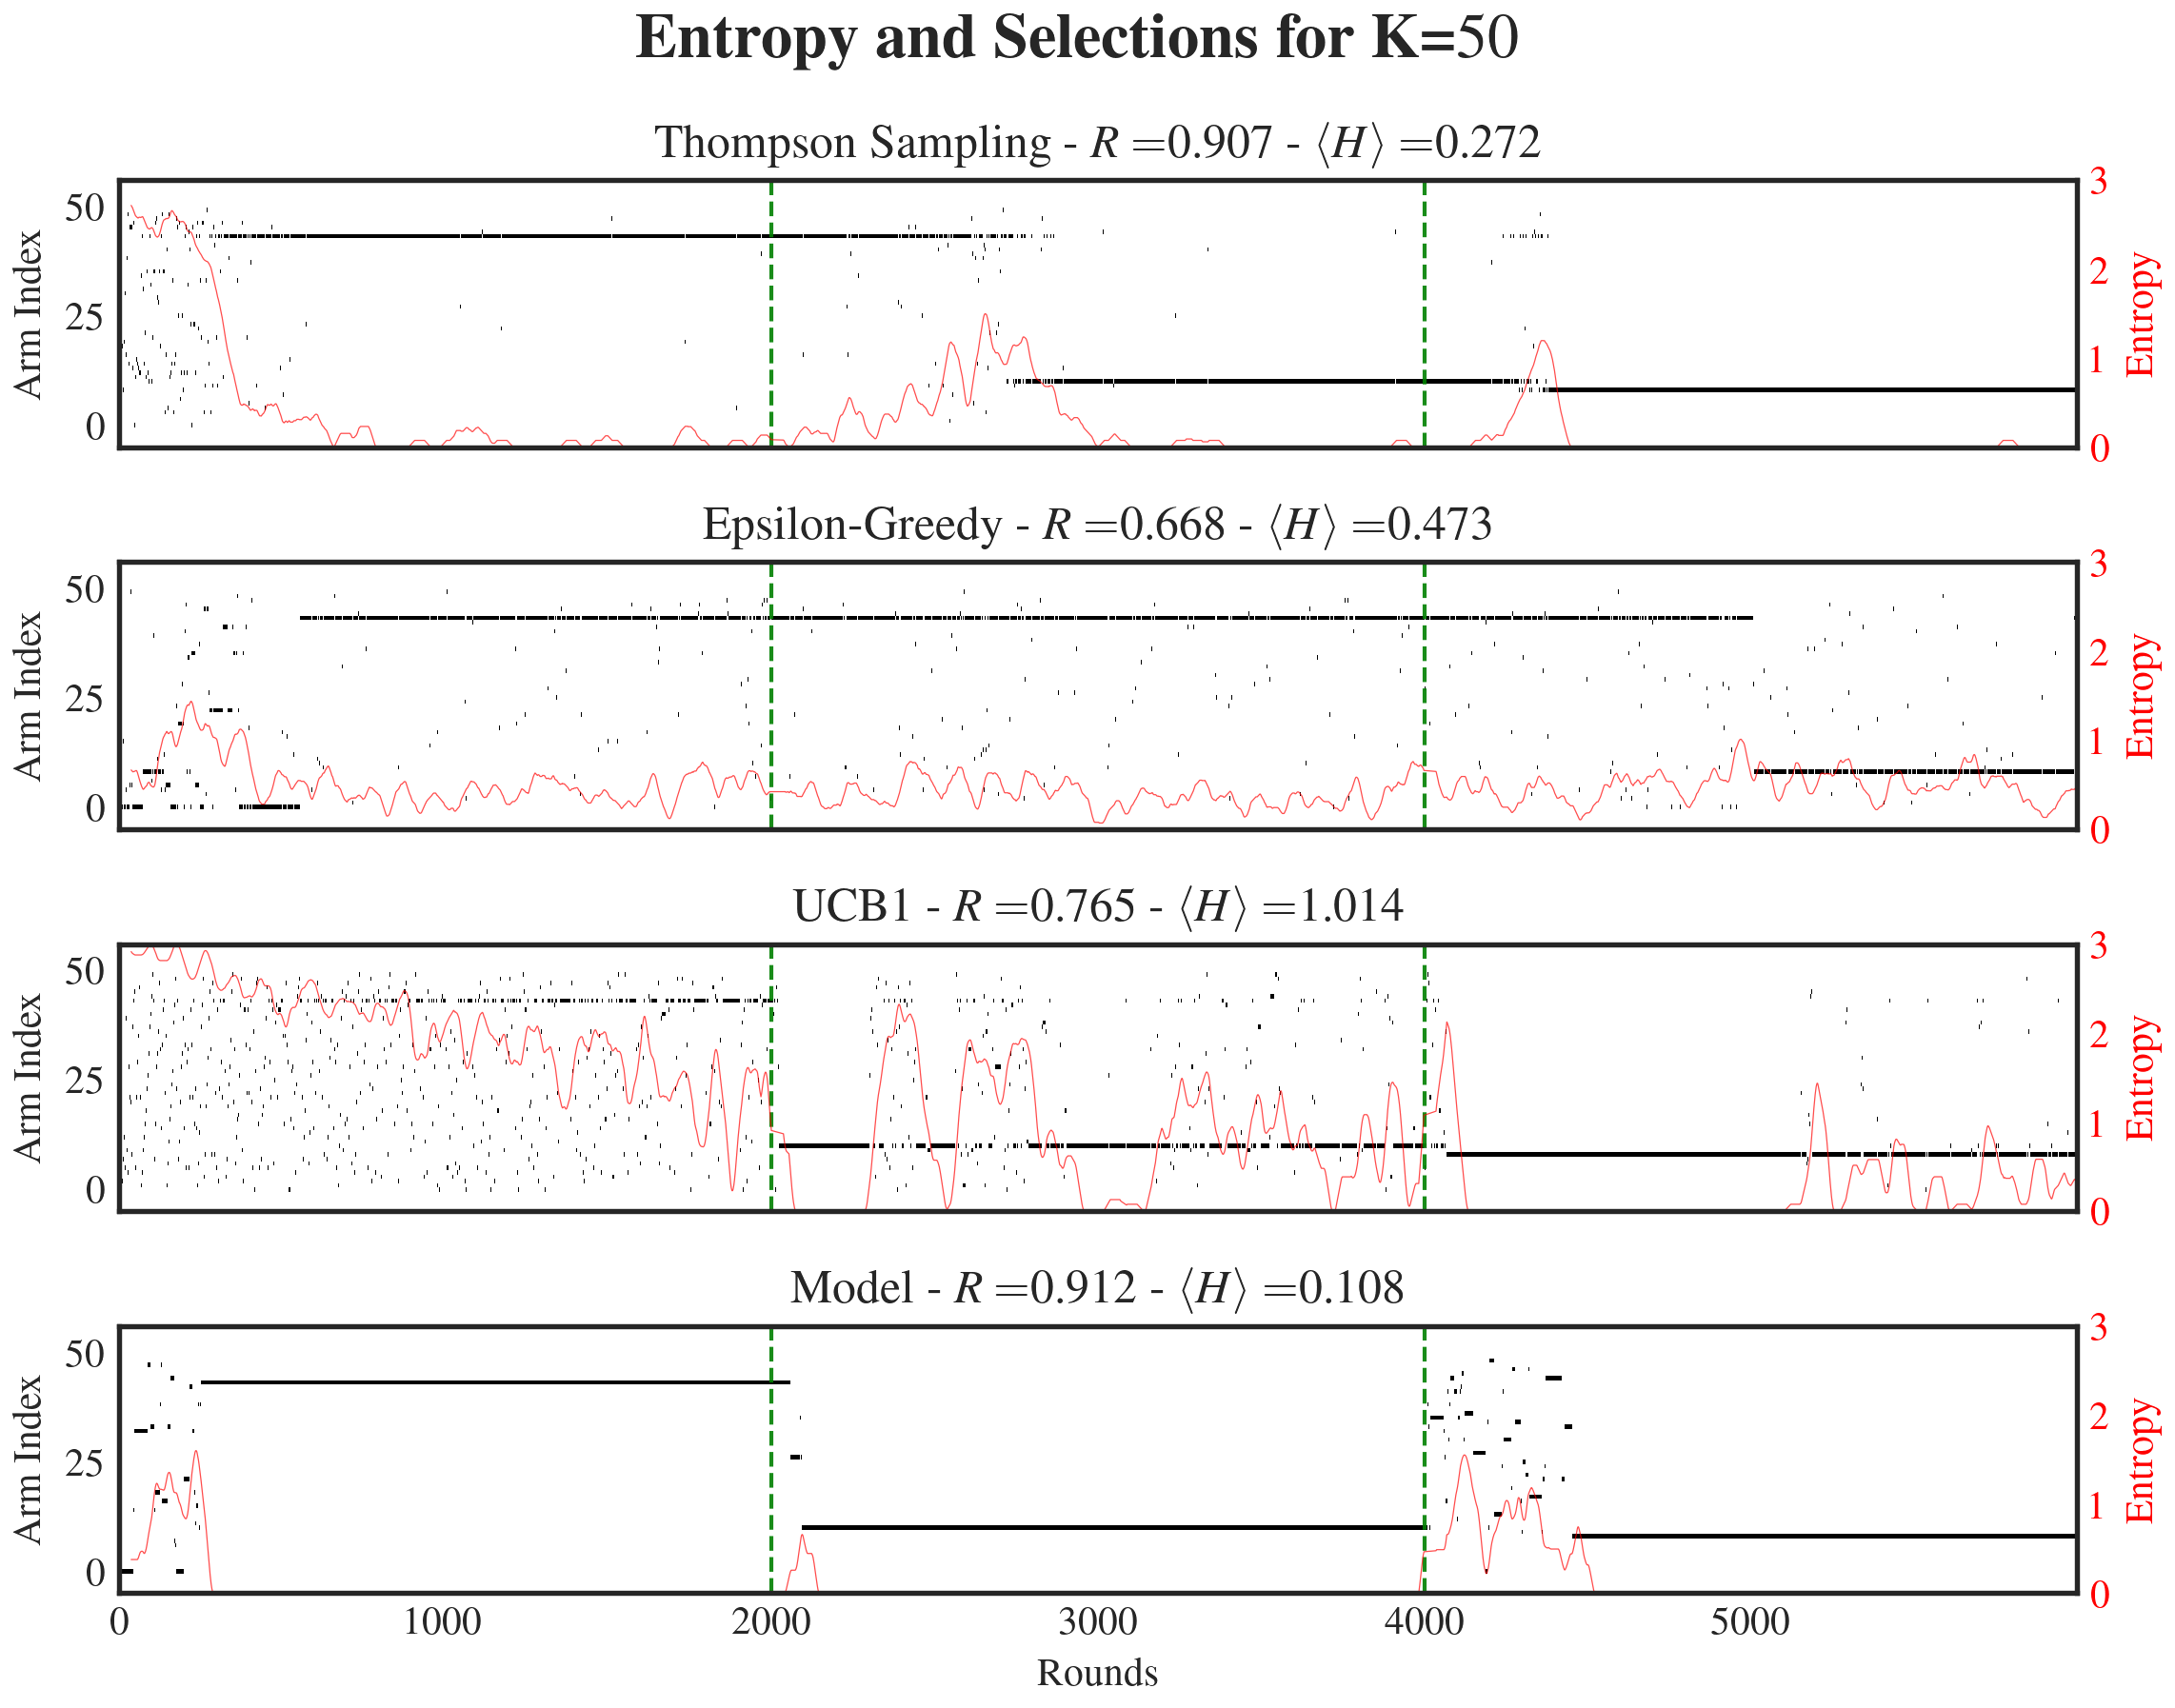

In [598]:
def plot_c(data, settings, save=False):
    
    k, v = settings.env, data
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times', 'Computer Modern Roman'],
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'figure.dpi': 300,
    })

    size = 50
    trials = settings.trials
    rounds = settings.rounds
    rep_i = 0
    K = settings.K

    print(f"[{k}]")
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    fig.tight_layout(pad=3.0, h_pad=2.0)
    
    twin_axs = [ax.twinx() for ax in axs]
    
    for i, (ax, twin_ax) in enumerate(zip(axs, twin_axs)):
        # Heatmap plot
        heatmap_data = np.array(v['arm_list'][i]).reshape(rounds*trials, K).T
        im = ax.imshow(heatmap_data, cmap="Greys", aspect="auto", interpolation="nearest", vmin=0, vmax=1)
        
        # Add vertical lines for trial boundaries
        for t in range(0, trials):
            ax.axvline(x=t*rounds, color='green', linestyle='--', alpha=0.9)
        
        # Entropy plot on secondary y-axis
        entropy = np.array(v['entropy_list'][i]).reshape(-1)
        entr_diff = rounds - len(entropy)//trials

        entropy = np.convolve(entropy, np.ones(size), mode="valid") / size
        x_entr = list(range(entr_diff + (size+1)//trials-1, rounds)
                     ) + list(range(entr_diff + (size+1)//trials-1 + rounds, rounds*2)
                             )+ list(range(entr_diff + (size+1)//trials-1 + 2*rounds, rounds*3))
        #for i in range(trials):
        #    x_entr += list(range(rounds*i+(i>0)*size+(i>1)*(entr_diff), rounds*(i+1)))
        
        entropy_line = twin_ax.plot(x_entr[1:], entropy, alpha=0.7, 
                                    color='red', lw=0.3, label='Entroy')
        
        # Formatting primary axis (heatmap)
        ax.set_ylim((-5, K+6))
        ax.set_ylabel('Arm Index')
        
        # Formatting secondary axis (entropy)
        twin_ax.set_ylabel('Entropy', color='red')
        twin_ax.tick_params(axis='y', labelcolor='red')
        twin_ax.set_ylim((0, 3))
        
        # Title with performance metrics
        ax.set_title(f"{v['names'][i][1:-1]} - $R=${v['scores'][i]:.3f} - $\\langle H \\rangle=${entropy.mean():.3f}")
        
        # X-axis label for the bottom subplot
        axs[-1].set_xlabel('Rounds')
        
        # Adjust layout and add a overall title
        plt.suptitle(r'\textbf{Entropy and Selections for K=}' + f'${settings1.K}$', fontsize=16, y=1.02)

        if save:
            plt.savefig(f'performance_analysis_{k}.png', 
                    bbox_inches='tight', 
                    dpi=500)
            print("saved")
        
    plt.show()



plot_c(data=results_entr, settings=settings1, save=False)

In [602]:
utils.calc_entropy(probabilities_set)

2.0242613131662983

---
#### {performance | entropy} vs reward_entropy

In [3]:
def run_(settings, probabilities_set, params):
    
    # parameters
    K = settings1.K
    nb_rounds = settings1.rounds
    nb_trials = settings1.trials
    nb_reps = settings1.reps
    verbose = settings1.verbose
    env_type = settings1.env
    
    
    # define the environment
    if env_type == "driftv0":
        env = envs.KABdriftv0(K=K,
                              probabilities_set=probabilities_set,
                              verbose=verbose,
                              tau=5)
    elif env_type == "driftv1":
        env = envs.KABdriftv1(K=K,
                              verbose=verbose,
                              tau=100,
                              normalize=True,
                              fixed_p=0.9)
    elif env_type == "sinv0":
        frequencies = np.linspace(0, 0.4, K)
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            normalize=True,
                            verbose=verbose)
    else:
        env = envs.KABv0(K=K,
                         probabilities_set=probabilities_set,
                         verbose=verbose)
    
    if verbose:
        logger.info(f"%env: {env}")
    
    # define models
    params["K"] = K
    
    
    model_list = [
        mm.ThompsonSampling(K=K),
        mm.EpsilonGreedy(K=K, epsilon=0.1),
        mm.UCB1(K=K),
        mm.Model(**params)
    ]
    
    # run
    results = envs.trial_multiple_models(
                         models=model_list,
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         entropy_calc=True,
                         verbose=settings1.verbose)
    return results

def softmax(z, beta):
    return np.exp(beta*z) / np.exp(beta*z).sum()

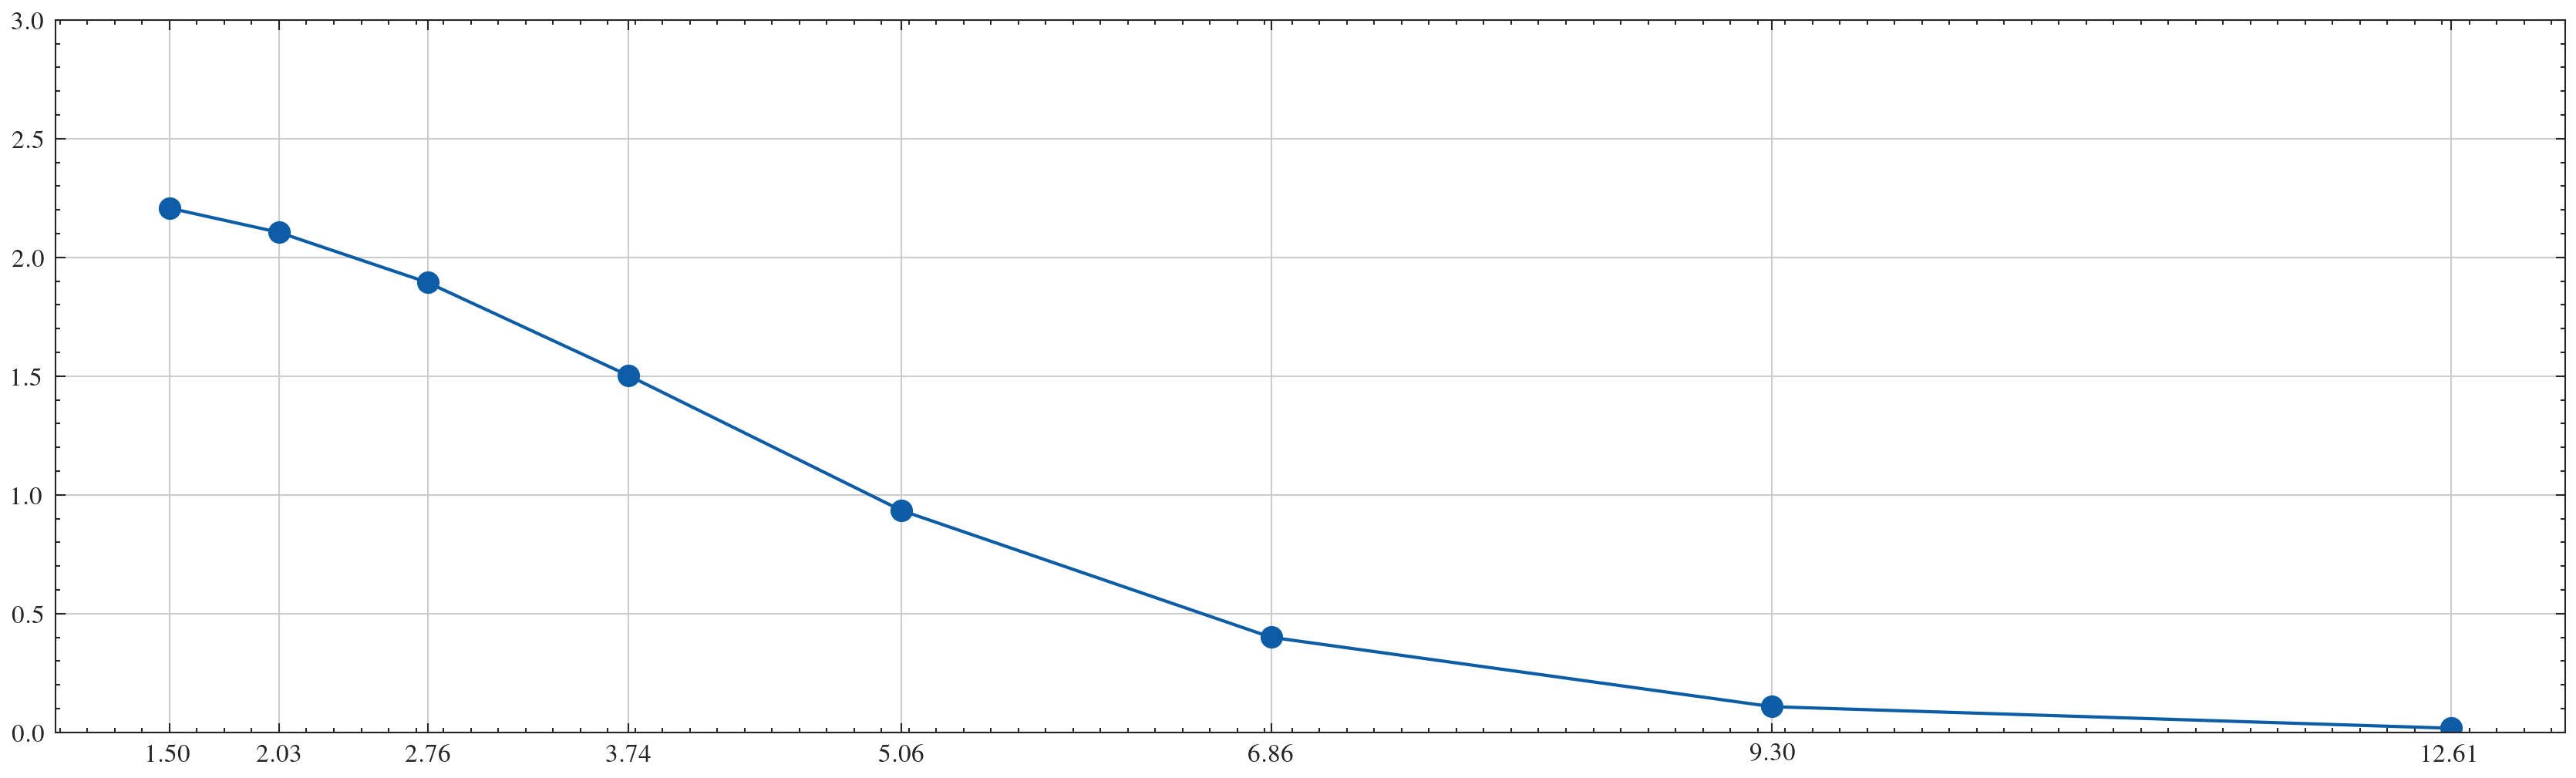

In [210]:
p = np.around(np.random.uniform(0.05, 0.5, settings1.K), 2)
p[0] = 1.

beta_values = 1.5**(np.arange(1, 7, 0.75))
out = [utils.calc_entropy(softmax(p, yi)) for yi in beta_values]
plt.figure(figsize=(14, 4))
plt.plot(beta_values, out, '-o')
plt.grid()
plt.ylim((0, 3))
plt.xticks(beta_values);

In [13]:
model_params = utils.load_model(idx=6) # 1

In [49]:
""" settings """
settings1 = Settings()
settings1.rounds = 200
settings1.trials = 2
settings1.reps = 1
settings1.verbose = False
settings1.idx = 6
settings1.load = True
settings1.env = "v0"
settings1.K = 10
NUM_BETAS = 5

""" parameters """
#beta_values = 1.5**(np.arange(7, 1, -0.75))
beta_values = 1.5**np.linspace(7, 1, NUM_BETAS)
probability = np.around(np.random.uniform(0.05, 0.5, settings1.K), 2)
probability[0] = 0.9 

""" main loop """
prob_entropy = []
model_entropy = []
model_reward = []
model_entropy_std = []
model_reward_std = []
upper_list = []

for beta in tqdm(beta_values):

    #logger(f"running {beta=:.4f}")

    # define proababilities 
    p = softmax(probability, beta)
    probabilities_set = np.array([p.tolist()])
    prob_entropy += [utils.calc_entropy(p)]

    """ run """
    results = run_(settings1, probabilities_set, model_params)
    model_reward += [results["scores"]]
    model_reward_std += [results["score_list"].mean(axis=2).std(axis=1)] 
    upper_list += [results["upper_bound_list"]]
    for i in range(settings1.trials):
        model_entropy += [results["entropy_list"][:, :, i, :].mean(axis=2).mean(axis=1)]
        model_entropy_std += [results["entropy_list"][:, :, i, :].mean(axis=2).std(axis=1)]

model_reward = np.array(model_reward)
model_entropy = np.array(model_entropy)
model_reward_std = np.stack(model_reward_std)
model_entropy_std = np.stack(model_entropy_std)

logger(f"reward: {model_reward.shape}")
logger(f"entropy: {model_entropy.shape}")
tot = len(prob_entropy)

logger("done")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.89s/it]
2024-12-05 22:18:27 | reward: (5, 4)
2024-12-05 22:18:27 | entropy: (10, 4)
2024-12-05 22:18:27 | done


In [50]:
results.keys()

dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'names', 'entropy_list'])

In [208]:
names = ['Thompson Sampling', 'Epsilon-Greedy', 'UCB1', 'Model']
tot = 1#len(1)
tot

1

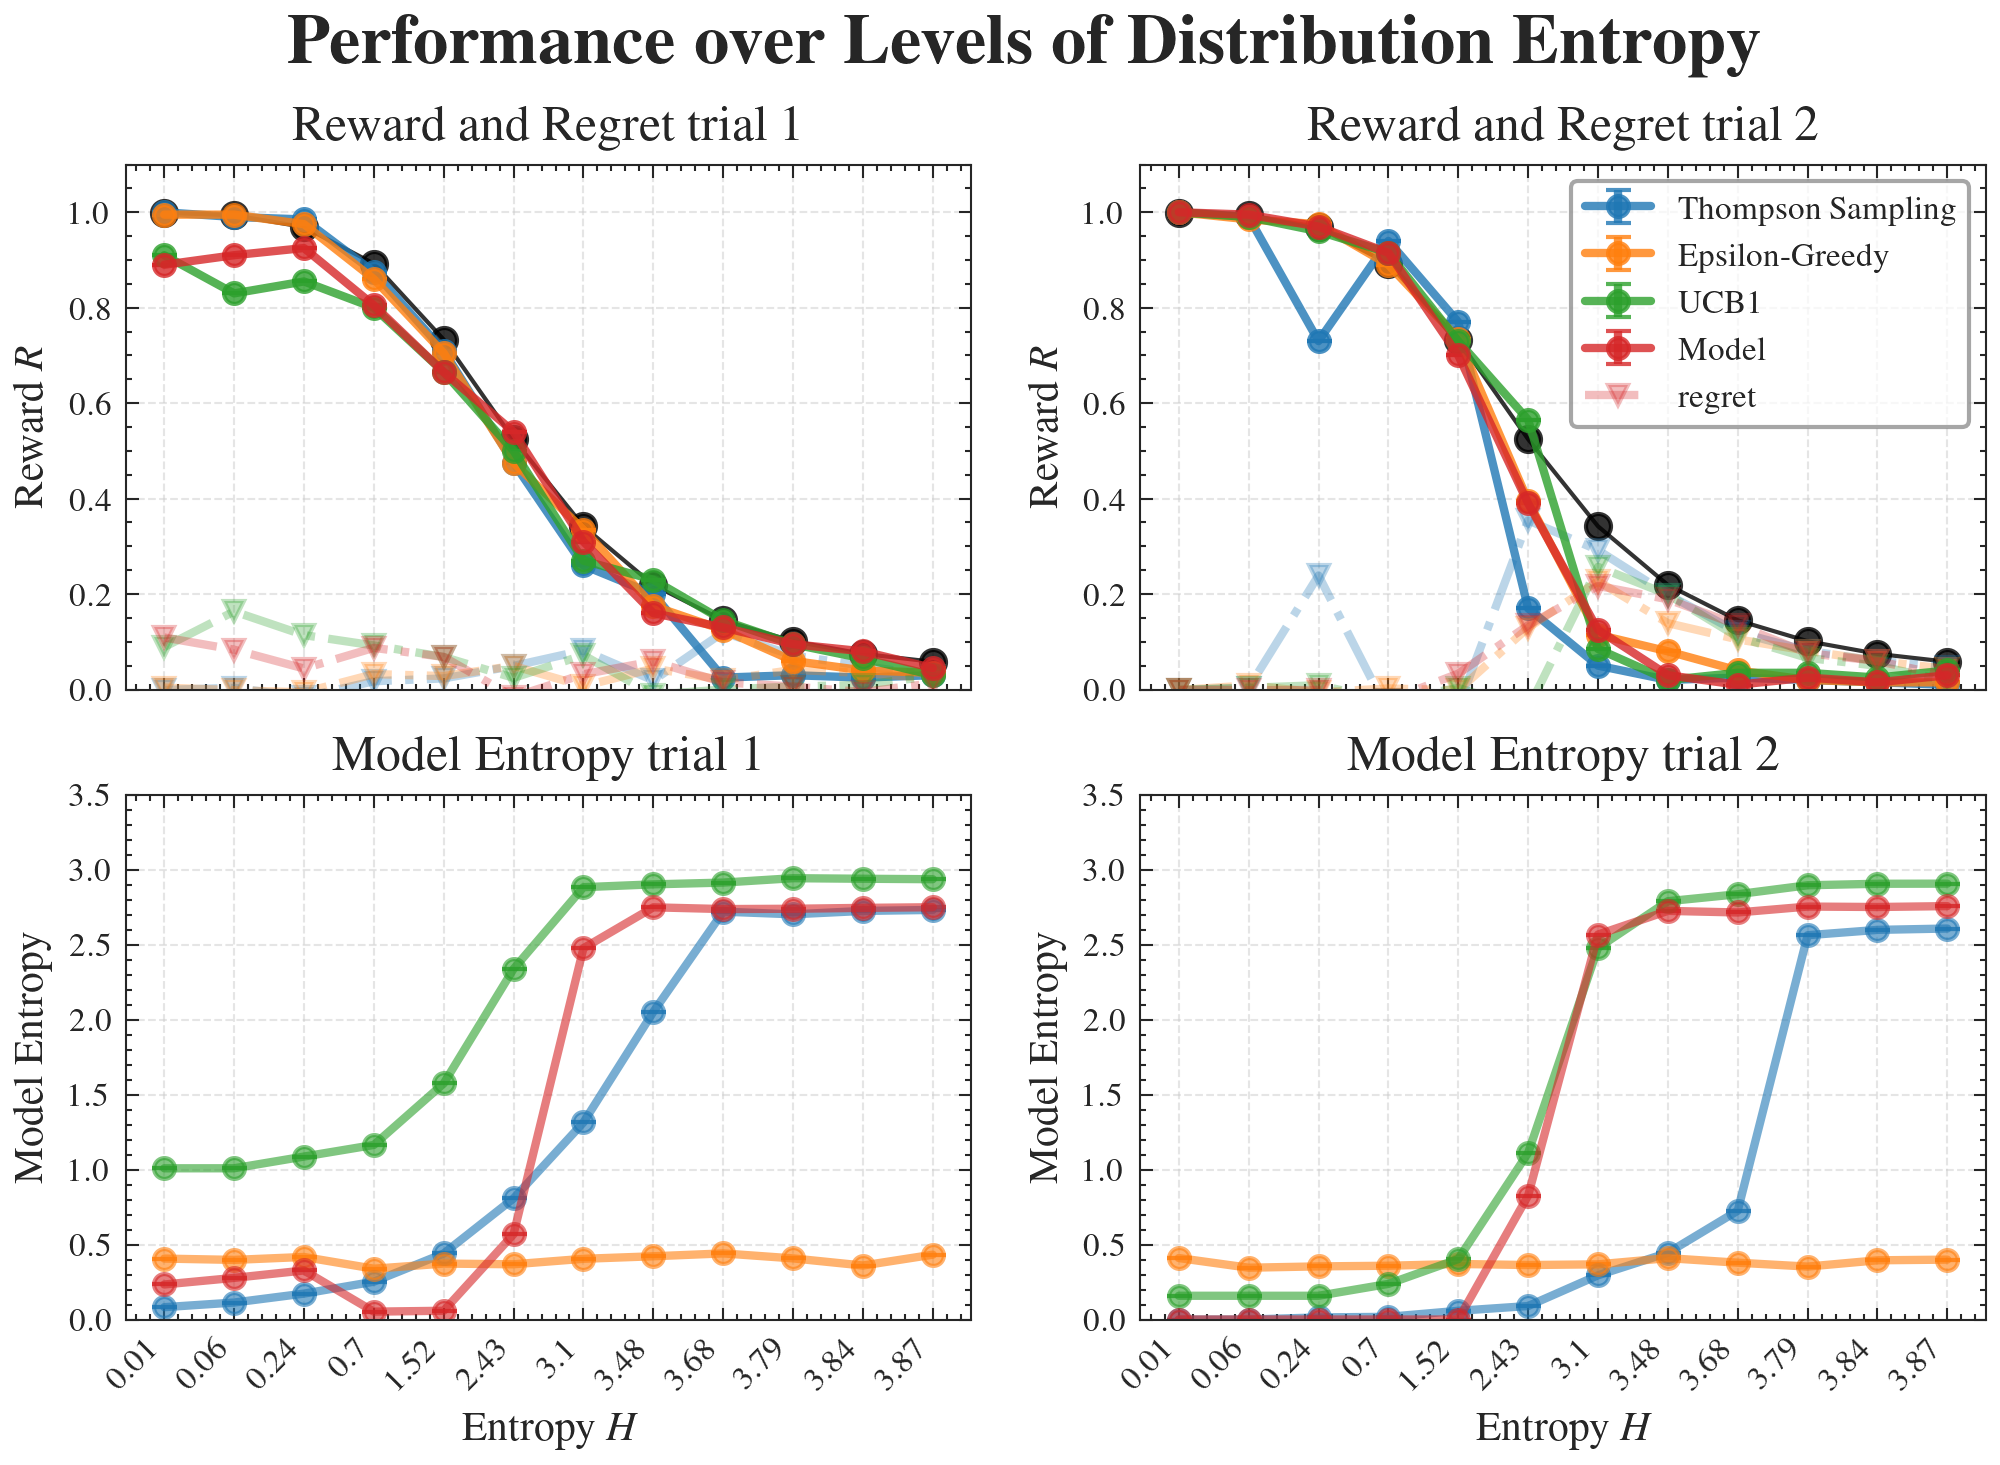

In [488]:
plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

tot = len(prob_entropy)

# Create figure with improved layout
fig, (axr, axe) = plt.subplots(2, 2, figsize=(8, 5), 
                               sharex=True, 
                               constrained_layout=False)
axr1, axr2 = axr
axe1, axe2 = axe

# Colorblind-friendly color palette
colors = sns.color_palette("tab10", len(names))

axr1.plot(range(tot), upper_list[idx1], '-o', color="black", alpha=0.8, label="Max")
axr2.plot(range(tot), upper_list[idx2], '-o', color="black", alpha=0.8)

idx1 = np.arange(0, tot*2, 2)
idx2 = np.arange(1, tot*2, 2)
# Reward plot (top subplot)
for i, name in enumerate(names):

    # -- reward trial 1
    axr1.errorbar(range(tot), 
                model_reward[idx1, i],
                yerr=model_reward_std[idx1, i],
                fmt='-o', 
                color=colors[i],
                capsize=3,
                linewidth=2,
                alpha=0.8,
                markersize=5)

    # -- reward trial 2
    axr2.errorbar(range(tot), 
                model_reward[idx2, i],
                yerr=model_reward_std[idx2, i],
                fmt='-o', 
                color=colors[i],
                label=name,
                capsize=3,
                linewidth=2,
                alpha=0.8,
                markersize=5)

    # -- regret trial 2
    # label
    if i == 3:
        axr2.errorbar(range(tot), 
                upper_list[idx2] - model_reward[idx2, i],
                fmt='-.v', 
                color=colors[i],
                capsize=3,
                linewidth=2,
                label="regret",
                alpha=0.3,
                markersize=5)
    else:
        axr2.errorbar(range(tot), 
                upper_list[idx2] - model_reward[idx2, i],
                fmt='-.v', 
                color=colors[i],
                capsize=3,
                linewidth=2,
                alpha=0.3,
                markersize=5)
    
    # -- regret trial 1
    axr1.errorbar(range(tot), 
            upper_list[idx1] - model_reward[idx1, i],
            fmt='-.v', 
            color=colors[i],
            capsize=3,
            linewidth=2,
            alpha=0.3,
            markersize=5)

axr2.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7, 
          edgecolor='gray')
axr1.grid(alpha=0.5, linestyle='--')

axr1.set_title(r'{Reward and Regret trial 1}')
axr1.set_ylabel(r"Reward $R$")
axr1.set_ylim((0, 1.1))

axr2.grid(alpha=0.5, linestyle='--')
axr2.set_title(r'{Reward and Regret trial 2}')
axr2.set_ylabel(r"Reward $R$")
axr2.set_ylim((0, 1.1))


# Entropy plot (bottom subplot)
for i, name in enumerate(names):

    # -- entropy trial 1
    axe1.errorbar(range(tot), 
                 model_entropy[:, :,  i].reshape(-1)[idx1], 
                 yerr=model_entropy_std[:, :, i].reshape(-1)[idx1],
                 fmt='-o', 
                 color=colors[i],
                 capsize=3,
                 linewidth=2,
                 alpha=0.6,
                 markersize=5)

    # -- entropy trial 1
    axe2.errorbar(range(tot), 
                 model_entropy[:, :,  i].reshape(-1)[idx2], 
                 yerr=model_entropy_std[:, :, i].reshape(-1)[idx2],
                 fmt='-o', 
                 color=colors[i],
                 capsize=3,
                 linewidth=2,
                 alpha=0.6,
                 markersize=5)
        

axe1.set_xlabel(r"Entropy $H$")
axe1.set_ylabel(r"Model Entropy")
axe1.set_xticks(range(tot))
axe1.set_xticklabels(np.around(prob_entropy, 2), rotation=45, ha='right')
axe1.set_title(r'{Model Entropy trial 1}')
axe1.grid(alpha=0.5, linestyle='--')
axe1.set_ylim((0, 3.5))

axe2.set_xlabel(r"Entropy $H$")
axe2.set_ylabel(r"Model Entropy")
axe2.set_xticks(range(tot))
axe2.set_xticklabels(np.around(prob_entropy, 2), rotation=45, ha='right')
axe2.set_title(r'{Model Entropy trial 2}')
axe2.grid(alpha=0.5, linestyle='--')
axe2.set_ylim((0, 3.5))


# Overall figure title
fig.suptitle(r'\textbf{Performance over Levels of Distribution Entropy}', 
             fontsize=17, y=0.98)

# Save with high DPI for publication
#plt.savefig('entropy_performance_plot.png', dpi=500, bbox_inches='tight')
plt.show()

In [489]:
model_entropy_std

array([[[5.55111512e-17, 7.77156117e-16, 1.99840144e-15, 4.99600361e-16],
        [0.00000000e+00, 3.88578059e-16, 4.16333634e-16, 0.00000000e+00],
        [2.22044605e-16, 7.21644966e-16, 6.66133815e-16, 3.33066907e-16],
        [0.00000000e+00, 3.88578059e-16, 4.16333634e-16, 0.00000000e+00],
        [4.99600361e-16, 1.05471187e-15, 2.44249065e-15, 9.99200722e-16],
        [2.42861287e-17, 8.88178420e-16, 4.16333634e-16, 0.00000000e+00],
        [4.44089210e-16, 1.66533454e-16, 4.44089210e-16, 1.04083409e-16],
        [1.38777878e-17, 1.11022302e-15, 4.44089210e-16, 0.00000000e+00],
        [9.43689571e-16, 6.66133815e-16, 2.66453526e-15, 1.59594560e-16],
        [0.00000000e+00, 3.88578059e-16, 6.10622664e-16, 0.00000000e+00],
        [1.22124533e-15, 1.11022302e-15, 2.22044605e-15, 5.55111512e-16],
        [1.38777878e-16, 8.32667268e-16, 2.22044605e-16, 1.44328993e-15]],

       [[2.22044605e-15, 9.43689571e-16, 7.99360578e-15, 3.99680289e-15],
        [4.44089210e-16, 1.66533454e

In [418]:
len(prob_entropy), len(model_entropy[:tot, i]), model_entropy_std.shape, model_entropy[tot:, :,  i].shape

(1, 1, (2, 12, 4), (1, 12))

In [498]:
files = os.listdir(data_path)
files

['run_07122024_211519',
 'run_07122024_211543',
 'entropy_run_20241208-043107.json',
 'entropy_run_20241208-014741.json',
 'entropy_run_20241206-001613.json',
 'entropy_run_20241208-031200.json',
 'entropy_run_20241205-225936.json']

In [413]:
""" load data """
data_path = os.getcwd() + "/src/data"
files = os.listdir(data_path)
with open(f"{data_path}/{files[2]}", "r") as f:
    datae = json.load(f)

datae.keys()

dict_keys(['prob_entropy', 'model_reward', 'model_reward_std', 'model_entropy', 'model_entropy_std', 'upper_list'])

In [282]:
np.array(datae['model_reward']).shape

(5, 3, 4, 2)

In [486]:
model_reward = np.array(datae["model_reward"]).reshape(128, -1, 4).mean(axis=0)
model_reward_std = np.array(datae["model_reward"]).reshape(128, -1, 4).std(axis=0)

model_entropy = np.array(datae["model_entropy"]).reshape(128, 2, -1, 4).mean(axis=0)#.flatten()
model_entropy_std = np.array(datae["model_entropy"]).reshape(128, 2, -1, 4).std(axis=0)
prob_entropy = np.array(datae["prob_entropy"]).flatten()
upper_list = np.array(datae["upper_list"]).reshape(128, -1, 2).mean(axis=0).reshape(-1)

upper_list

array([0.99905341, 0.99905341, 0.99356264, 0.99356264, 0.9690164 ,
       0.9690164 , 0.89231908, 0.89231908, 0.73325706, 0.73325706,
       0.52446273, 0.52446273, 0.34200511, 0.34200511, 0.21906782,
       0.21906782, 0.14497905, 0.14497905, 0.10119778, 0.10119778,
       0.07474328, 0.07474328, 0.05816134, 0.05816134])

In [419]:
np.array(datae["model_reward"]).shape, np.array(datae["model_reward_std"]).shape, np.array(datae['prob_entropy']).shape

((128, 12, 4, 2), (128, 12, 4, 2), (1, 12))

In [487]:
model_entropy_std

array([[[5.55111512e-17, 7.77156117e-16, 1.99840144e-15, 4.99600361e-16],
        [0.00000000e+00, 3.88578059e-16, 4.16333634e-16, 0.00000000e+00],
        [2.22044605e-16, 7.21644966e-16, 6.66133815e-16, 3.33066907e-16],
        [0.00000000e+00, 3.88578059e-16, 4.16333634e-16, 0.00000000e+00],
        [4.99600361e-16, 1.05471187e-15, 2.44249065e-15, 9.99200722e-16],
        [2.42861287e-17, 8.88178420e-16, 4.16333634e-16, 0.00000000e+00],
        [4.44089210e-16, 1.66533454e-16, 4.44089210e-16, 1.04083409e-16],
        [1.38777878e-17, 1.11022302e-15, 4.44089210e-16, 0.00000000e+00],
        [9.43689571e-16, 6.66133815e-16, 2.66453526e-15, 1.59594560e-16],
        [0.00000000e+00, 3.88578059e-16, 6.10622664e-16, 0.00000000e+00],
        [1.22124533e-15, 1.11022302e-15, 2.22044605e-15, 5.55111512e-16],
        [1.38777878e-16, 8.32667268e-16, 2.22044605e-16, 1.44328993e-15]],

       [[2.22044605e-15, 9.43689571e-16, 7.99360578e-15, 3.99680289e-15],
        [4.44089210e-16, 1.66533454e

---

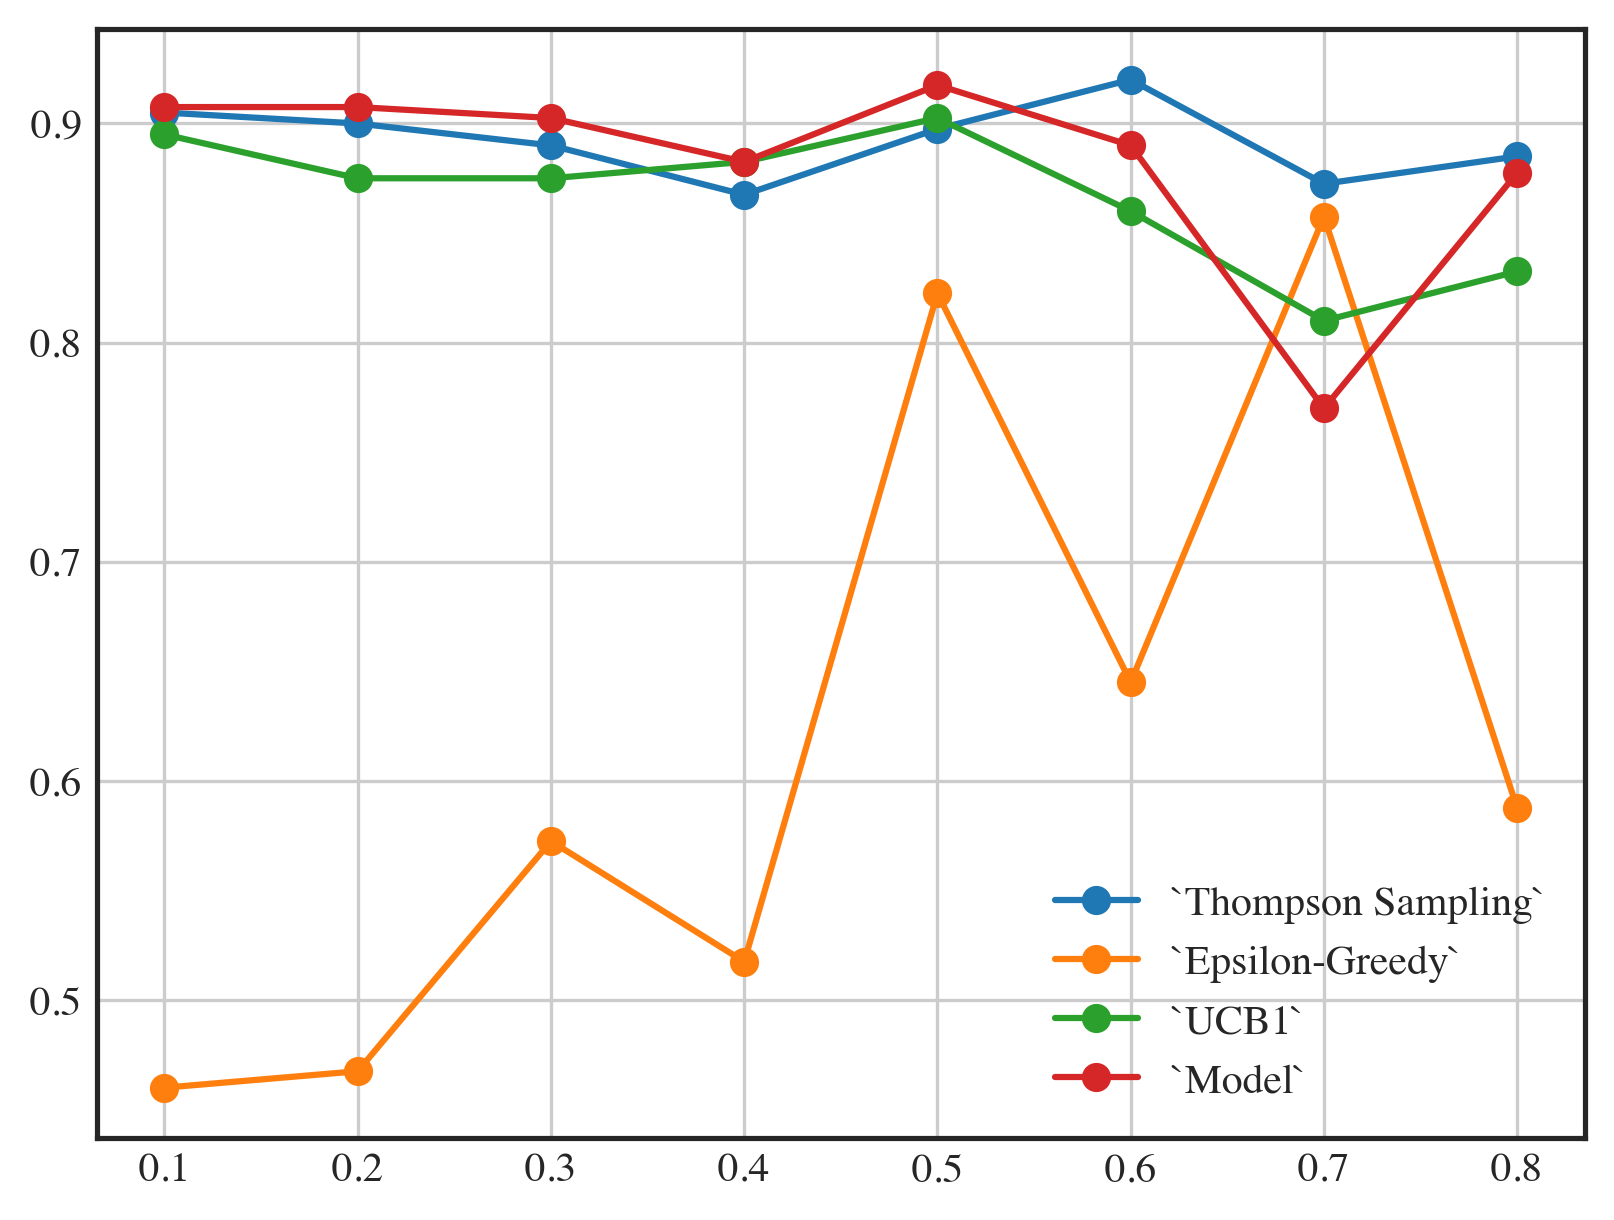

In [32]:
scores = np.zeros((4, len(up_list)))
names = all_results[up_list[0]]["names"]

for i, (k, v) in enumerate(all_results.items()):
    scores[:, i] = v["scores"]

fig, ax = plt.subplots()

for i, s in enumerate(scores):
    ax.plot(up_list, s, '-o', label=names[i])

ax.legend()
ax.grid()
plt.show()

#### Evolution plot

In [725]:
os.getcwd()

'/Users/daniekru/Research'

In [14]:
with open(f"{os.getcwd()}/src/_evo_cache/29_best.json", 'r') as f:
    evo_data = json.load(f)
    
#e_max, e_mean, e_std = genome['info']['fitness_record']
#cutoff_ = 70
#e_max = e_max[:cutoff_]
#e_mean = e_mean[:cutoff_]
#e_std = e_std[:cutoff_]
model_params = evo_data['genome']
evo_data['info'].keys(), model_params

(dict_keys(['date', 'model', 'game', 'evolved', 'data', 'other', 'performance', 'fitness_record']),
 {'tau_u': 63,
  'tau_v': 287,
  'gain_v': 22.5,
  'offset_v': 0.2,
  'threshold_v': 0.19,
  'gain_u': 20.9,
  'offset_u': 0.2,
  'threshold_u': 0.85,
  'alpha': 1.4,
  'beta': 9.5,
  'mu': -3.9,
  'sigma': 5.5,
  'r': 0.74,
  'alpha_lr': -4.7,
  'beta_lr': 8.0,
  'mu_lr': 1.2,
  'sigma_lr': 2.6,
  'r_lr': 0.13,
  'w_max': 4.2,
  'dur_pre': 2095,
  'dur_post': 1987})

In [3]:
with open(f"{os.getcwd()}/src/_evo_cache/29_best.json", 'r') as f:
    evo_data = json.load(f)
    
#e_max, e_mean, e_std = genome['info']['fitness_record']
#cutoff_ = 70
#e_max = e_max[:cutoff_]
#e_mean = e_mean[:cutoff_]
#e_std = e_std[:cutoff_]
model_params = evo_data['genome']
evo_data['info'].keys(), model_params

(dict_keys(['date', 'model', 'game', 'evolved', 'data', 'other', 'performance', 'fitness_record']),
 {'tau_u': 63,
  'tau_v': 287,
  'gain_v': 22.5,
  'offset_v': 0.2,
  'threshold_v': 0.19,
  'gain_u': 20.9,
  'offset_u': 0.2,
  'threshold_u': 0.85,
  'alpha': 1.4,
  'beta': 9.5,
  'mu': -3.9,
  'sigma': 5.5,
  'r': 0.74,
  'alpha_lr': -4.7,
  'beta_lr': 8.0,
  'mu_lr': 1.2,
  'sigma_lr': 2.6,
  'r_lr': 0.13,
  'w_max': 4.2,
  'dur_pre': 2095,
  'dur_post': 1987})

In [68]:
""" make data """
e_p84 - e_mean, e_mean - e_p16

(array([0.00548706, 0.00474731, 0.02055054, 0.01771118, 0.01688843,
        0.01869873, 0.01533569, 0.01469238, 0.0114563 , 0.00952637,
        0.00378296, 0.01401538, 0.18670044, 0.17578735, 0.15592896,
        0.17829956, 0.20737915, 0.22233105, 0.23767041, 0.24285742,
        0.2502771 , 0.20865479, 0.20065674, 0.18514478, 0.20363794,
        0.1983501 , 0.20111816, 0.21174463, 0.20143457, 0.20842651,
        0.19311816, 0.18748853]),
 array([0.31365841, 0.30537818, 0.31363088, 0.30922931, 0.31132721,
        0.29908343, 0.296492  , 0.28474213, 0.27735798, 0.2614941 ,
        0.25238588, 0.23834767, 0.26544779, 0.26252169, 0.2592592 ,
        0.27682887, 0.3063904 , 0.33513721, 0.3493069 , 0.38185621,
        0.36930541, 0.43823477, 0.4395588 , 0.46831044, 0.45811518,
        0.45383508, 0.45995046, 0.4380564 , 0.45761252, 0.4491337 ,
        0.48264877, 0.48297945]))

In [75]:
for i in range(cutoff):
    print(f"{e_p16[i]:.3f} - {e_mean[i]:.3f} - {e_p84[i]:.3f}")

0.025 - 0.338 - 0.344
0.034 - 0.339 - 0.344
0.029 - 0.342 - 0.363
0.036 - 0.345 - 0.363
0.035 - 0.347 - 0.363
0.049 - 0.348 - 0.367
0.055 - 0.351 - 0.367
0.067 - 0.352 - 0.367
0.084 - 0.362 - 0.373
0.103 - 0.365 - 0.374
0.118 - 0.370 - 0.374
0.132 - 0.370 - 0.384
0.131 - 0.396 - 0.583
0.146 - 0.408 - 0.584
0.171 - 0.431 - 0.587
0.192 - 0.469 - 0.647
0.208 - 0.515 - 0.722
0.211 - 0.546 - 0.769
0.217 - 0.566 - 0.804
0.221 - 0.603 - 0.846
0.229 - 0.598 - 0.848
0.223 - 0.662 - 0.870
0.229 - 0.668 - 0.869
0.216 - 0.684 - 0.870
0.228 - 0.686 - 0.890
0.240 - 0.694 - 0.892
0.231 - 0.691 - 0.892
0.242 - 0.680 - 0.892
0.245 - 0.703 - 0.904
0.250 - 0.699 - 0.907
0.238 - 0.720 - 0.914
0.233 - 0.716 - 0.903


In [81]:
np.array(evo_data['info']['fitness_record']['p84'])[:cutoff]

array([0.34375  , 0.34375  , 0.3628125, 0.3628125, 0.3634375, 0.3665625,
       0.3665625, 0.366875 , 0.373125 , 0.3740625, 0.3740625, 0.383875 ,
       0.5828125, 0.5840625, 0.5865625, 0.6475   , 0.7221875, 0.768625 ,
       0.8039375, 0.8461875, 0.8484375, 0.8703125, 0.8690625, 0.8695625,
       0.8900625, 0.892    , 0.891875 , 0.8919375, 0.904125 , 0.9075   ,
       0.9135625, 0.903    ])

In [15]:
cutoff = 40
e_mean = np.array(evo_data['info']['fitness_record']['max'])[:cutoff]
e_max = np.array(evo_data['info']['fitness_record']['std'])[:cutoff]
e_p16 = np.array(evo_data['info']['fitness_record']['mean'])[:cutoff]
e_p84 = np.array(evo_data['info']['fitness_record']['p84'])[:cutoff]

In [39]:
evo_data['info']['performance']

{'gen': '33', 'fitness': '[0.94219]'}

In [6]:
model_params = evo_data['genome']
model_params.keys()

dict_keys(['tau_u', 'tau_v', 'gain_v', 'offset_v', 'threshold_v', 'gain_u', 'offset_u', 'threshold_u', 'alpha', 'beta', 'mu', 'sigma', 'r', 'alpha_lr', 'beta_lr', 'mu_lr', 'sigma_lr', 'r_lr', 'w_max', 'dur_pre', 'dur_post'])

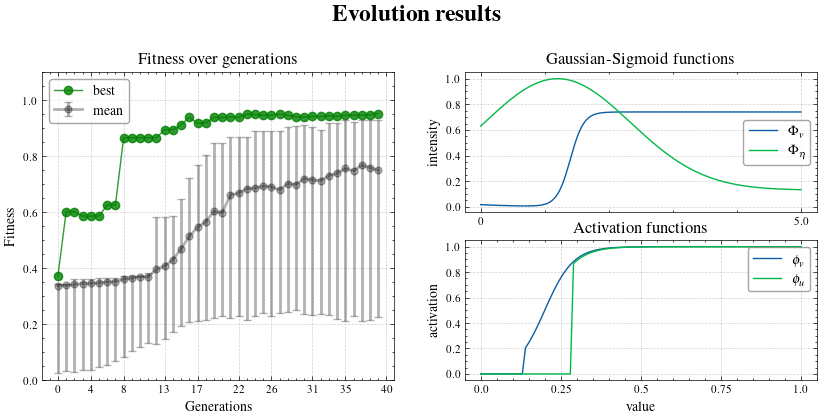

In [18]:
plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Create figure with improved layout
fig = plt.figure(figsize=(10, 4))
fig.tight_layout()
gs = GridSpec(2, 2, figure=fig)

# Single plot in the first column (spans two rows)
ax = fig.add_subplot(gs[:, 0])

# Two plots in the second column
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

# Colorblind-friendly color palette
#colors = sns.color_palette("tab10", len(names))

xr = range(cutoff)

# ==============================================================
# === evolution

ax.plot(xr, e_max, '-o', color="green", alpha=0.8, label="best")

# p16 : array 
# p84 : array 

ax.errorbar(xr, 
            e_mean,
            yerr=[e_mean-e_p16, e_p84 - e_mean],
            fmt='-o', 
            color="black",
            label="mean",
            capsize=3,
            linewidth=2,
            alpha=0.3,
            markersize=5)

ax.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7, 
          edgecolor='gray')

ax.set_title(r'{Fitness over generations}')
ax.set_ylabel(r"Reward $R$")
ax.set_ylim((0, 1.1))

ax.set_xlabel(r"Generations")
ax.set_ylabel(r"Fitness")
ax.set_xticks(np.linspace(0, len(e_max), 10).astype(int))
ax.set_xticklabels(np.linspace(0, len(e_max), 10).astype(int))
ax.grid(alpha=0.6, linestyle='--')

# ==============================================================
# === function

x = np.arange(0, 5+0.01, 0.01)
y = utils.gaussian_sigmoid(x, 
                     alpha=model_params["alpha"],
                     beta=model_params["beta"],
                     mu=model_params["mu"],
                     sigma=model_params["sigma"],
                     r=model_params["r"])

y2 = utils.gaussian_sigmoid(x, 
                     alpha=model_params["alpha_lr"],
                     beta=model_params["beta_lr"],
                     mu=model_params["mu_lr"],
                     sigma=model_params["sigma_lr"],
                     r=model_params["r_lr"])
ax1.plot(x, y, label="$\\Phi_v$")
ax1.plot(x, y2, label="$\\Phi_{{\\eta}}$")

#ax1.set_xlabel(r"weight value", fontsize=15, x=0.8)
ax1.set_ylabel(r"intensity")
ax1.set_xticks((0, x.max()))
ax1.set_xticklabels((0, x.max()))
ax1.grid(alpha=0.6, linestyle='--')
ax1.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7, 
          edgecolor='gray')
ax1.set_title(r'{Gaussian-Sigmoid functions}')

# ==============================================================
# === activation functions

x1 = np.arange(0, 1+0.01, 0.01)
#y3 = utils.generalized_sigmoid(x1, 
#                     threshold=model_params["threshold"],
#                     gain=model_params["gain"])
yv = utils.neural_response_func(x=x1,
                     gain=model_params["gain_v"],
                     offset=model_params["offset_v"],
                     threshold=model_params["threshold_v"])
yu = utils.neural_response_func(x=x1,
                     gain=model_params["gain_u"],
                     offset=model_params["offset_u"],
                     threshold=model_params["threshold_u"])

ax2.plot(x1, yv, label="$\\phi_{v}$")
ax2.plot(x1, yu, label="$\\phi_{u}$")


ax2.set_xlabel(r"value")
ax2.set_ylabel(r"activation")
ax2.set_xticks(np.arange(0, x1.max()+0.01, 0.25))
ax2.set_xticklabels(np.arange(0, x1.max()+0.01, 0.25))
ax2.grid(alpha=0.6, linestyle='--')
ax2.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7,
          edgecolor='gray')
ax2.set_title(r'{Activation functions}')

# ==============================================================
# === Overall figure title

fig.suptitle(r'\textbf{Evolution results}', 
             fontsize=17, y=1.05)

# Save with high DPI for publication
plt.savefig('paper/figures/evolution_plot.png', dpi=500, bbox_inches='tight')
plt.show()

#### function tuning

In [7]:
model_params = utils.load_model(idx=16)
model_params

{'tau_u': 63,
 'tau_v': 287,
 'gain_v': 22.5,
 'offset_v': 0.2,
 'threshold_v': 0.19,
 'gain_u': 20.9,
 'offset_u': 0.2,
 'threshold_u': 0.85,
 'alpha': 1.4,
 'beta': 9.5,
 'mu': -3.9,
 'sigma': 5.5,
 'r': 0.74,
 'alpha_lr': -4.7,
 'beta_lr': 8.0,
 'mu_lr': 1.2,
 'sigma_lr': 2.6,
 'r_lr': 0.13,
 'w_max': 4.2,
 'dur_pre': 2095,
 'dur_post': 1987}

In [10]:
nb_rounds = 2000
nb_trials = 1
nb_reps = 2
K = 1000

probabilities_set = utils.make_probability_set(K=K,
                                               nb_trials=nb_trials,
                                               fixed_p=0.9,
                                               normalize=False)

env = envs.KABv0(K=K,
                 probabilities_set=probabilities_set,
                 verbose=False)

""" run """
model_params['K'] = K
model_params['weights_history'] = True
model = mm.Model(**model_params)
results = envs.trial_multiple_models(
                         models=[model],
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         entropy_calc=True,
                         verbose=True)
logger(f"scores: {results['score_list']}")

2024-12-11 23:15:22 | Invalid parameters for Model, using Modelv2 instead
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:24<00:00, 192.29s/it]
2024-12-11 23:21:46 | scores: [[[0.915]
  [0.89 ]]]


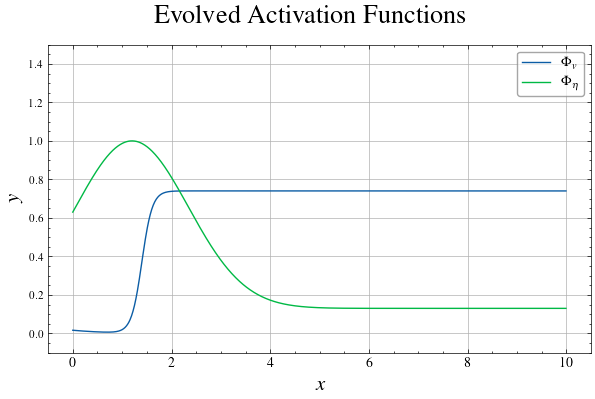

In [28]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
})
    
x = np.arange(0, 10, 0.01)
y = utils.gaussian_sigmoid(x, 
                     alpha=model_params["alpha"],
                     beta=model_params["beta"],
                     mu=model_params["mu"],
                     sigma=model_params["sigma"],
                     r=model_params["r"])

y2 = utils.gaussian_sigmoid(x, 
                     alpha=model_params["alpha_lr"],
                     beta=model_params["beta_lr"],
                     mu=model_params["mu_lr"],
                     sigma=model_params["sigma_lr"],
                     r=model_params["r_lr"])

fig, ax = plt.subplots(figsize=(7, 4))
fig.suptitle("Evolved Activation Functions",
             fontsize=19)
ax.plot(x, y, label="$\\Phi_v$")
ax.plot(x, y2, label="$\\Phi_{{\\eta}}$")

ax.set_xlabel("$x$", fontsize=15)
ax.set_ylabel("$y$", fontsize=15)
ax.set_ylim((-0.1, 1.5))
ax.grid()
ax.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7, 
          edgecolor='gray')
#fig.savefig("paper/figures/function_evo.png",
#                 dpi=500, bbox_inches="tight")
plt.show()


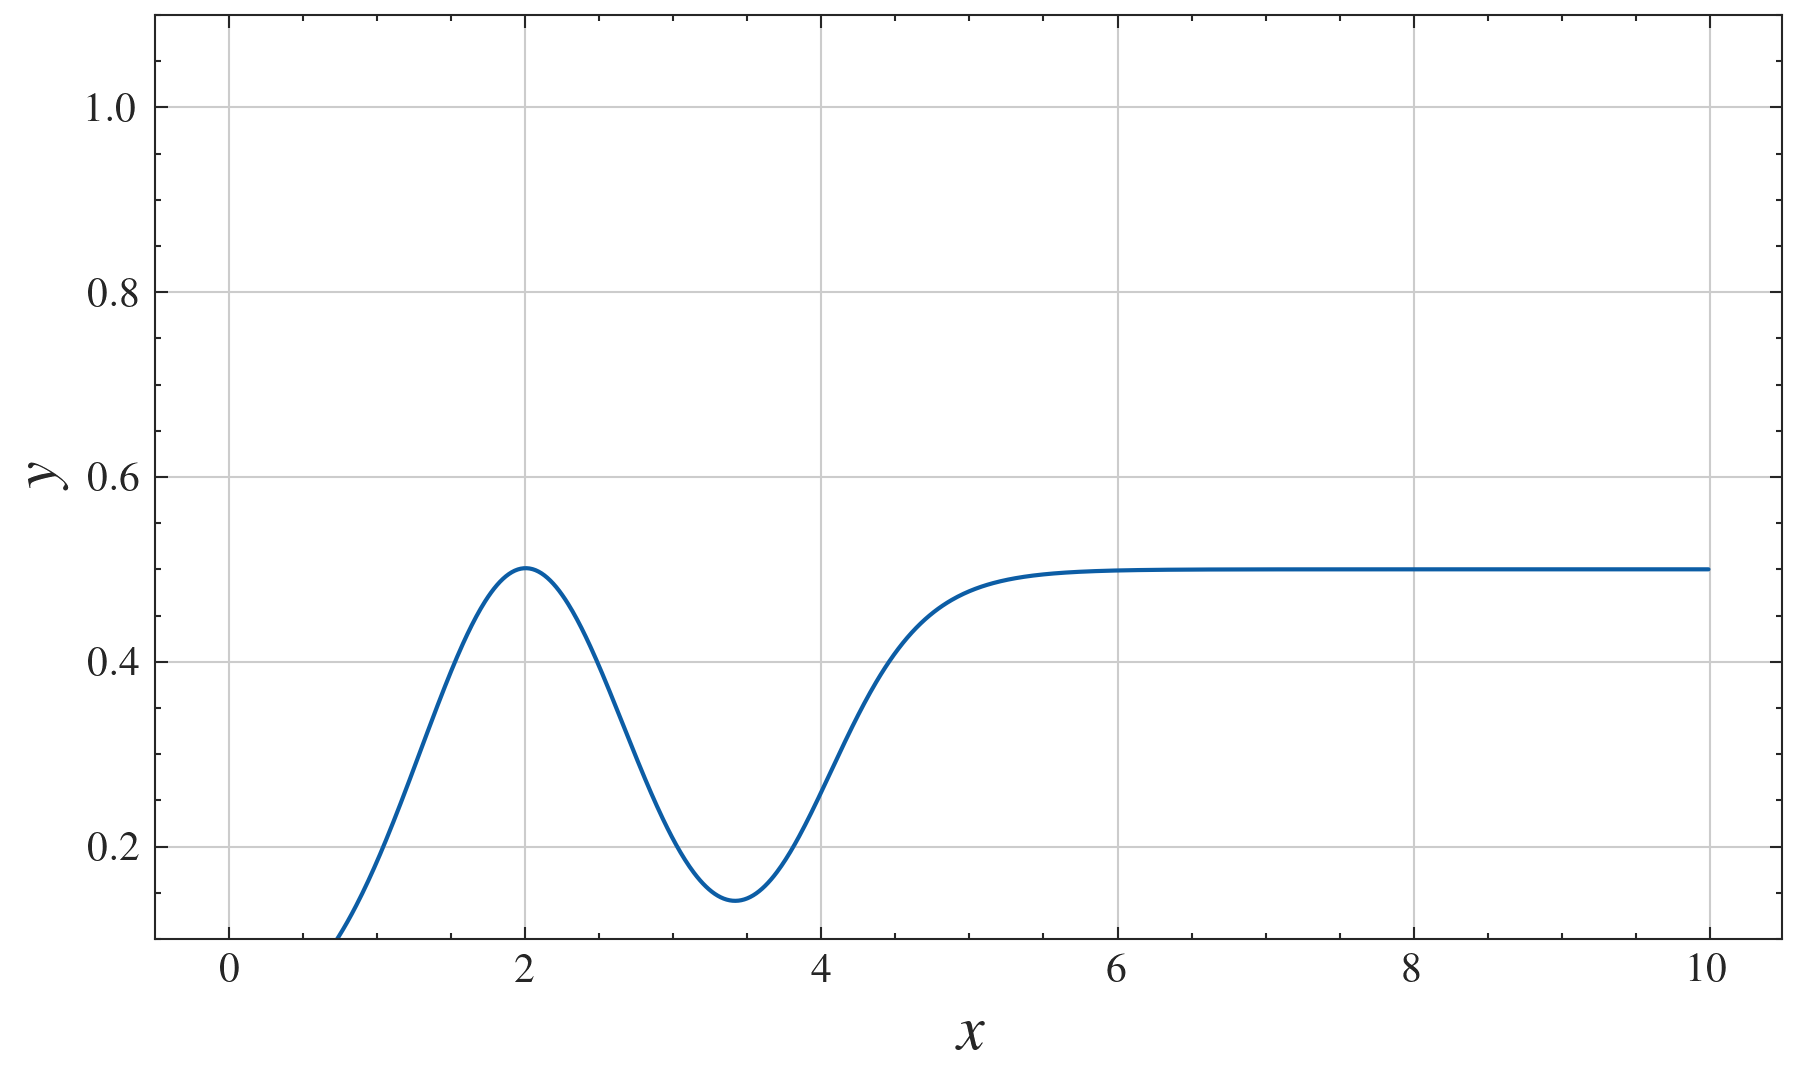

In [582]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

x = np.arange(0, 10, 0.01)
y = utils.gaussian_sigmoid(x, 
                     alpha=4,
                     beta=3,
                     mu=2,
                     sigma=1,
                     r=0.5)


fig, ax = plt.subplots(figsize=(7, 4))
#fig.suptitle("Gaussian Sigmoid function",
#             fontsize=19)
ax.plot(x, y)

ax.set_xlabel("$x$", fontsize=15)
ax.set_ylabel("$y$", fontsize=15)
ax.set_ylim((0.1, 1.1))
ax.grid()
#ax.legend()
plt.show()
fig.savefig("paper/figures/gaussian_sigmoid.png",
                 dpi=500, bbox_inches="tight")


In [16]:
os.getcwd()

'/Users/daniekru/Research/lab/minBandit'

In [10]:
model_params

{'tau_u': 63,
 'tau_v': 287,
 'gain_v': 22.5,
 'offset_v': 0.2,
 'threshold_v': 0.19,
 'gain_u': 20.9,
 'offset_u': 0.2,
 'threshold_u': 0.85,
 'alpha': 1.4,
 'beta': 9.5,
 'mu': -3.9,
 'sigma': 5.5,
 'r': 0.74,
 'alpha_lr': -4.7,
 'beta_lr': 8.0,
 'mu_lr': 1.2,
 'sigma_lr': 2.6,
 'r_lr': 0.13,
 'w_max': 4.2,
 'dur_pre': 2095,
 'dur_post': 1987,
 'K': 200}

TypeError: Invalid shape (0,) for image data

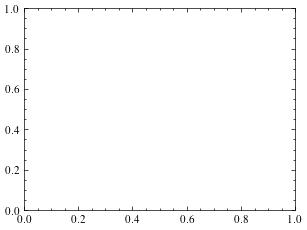

In [70]:
plt.imshow(model.get_weights_record().T, cmap="RdBu_r", aspect="auto")
plt.colorbar()
plt.show()

In [14]:
# ---
model_params['weights_history'] = False

nb_rounds = 1000
nb_trials = 1
nb_reps = 1
K = 10

# ---
N = 20
gain_values = np.linspace(-2, 2, N)

# ---
model_params = utils.load_model(idx=6)
model_params["K"] = K

z = np.zeros(N)
for i, g in tqdm(zip(range(N), gain_values)):
    print(f"[{i=}] {g=:.4f}")
    model_params = utils.load_model(idx=6)
    model_params["K"] = K
    model_params["beta_lr"] = g
    #model_params["alpha_lr"] = 
    model_params["r_lr"] = 1.
    model_params["lr"] = 1.
    model = mm.Model(**model_params)
    results = envs.trial_multiple_models(
                             models=[model],
                             environment=env,
                             nb_trials=nb_trials,
                             nb_rounds=nb_rounds,
                             nb_reps=nb_reps,
                             entropy_calc=True,
                             verbose=False)
    z[i] = results["scores"].item()

logger("done")

0it [00:00, ?it/s]

[i=0] g=-2.0000


1it [00:24, 24.06s/it]

[i=1] g=-1.7895


2it [00:47, 23.94s/it]

[i=2] g=-1.5789


3it [01:11, 23.95s/it]

[i=3] g=-1.3684


4it [01:35, 23.89s/it]

[i=4] g=-1.1579


5it [01:59, 24.00s/it]

[i=5] g=-0.9474


6it [02:23, 23.95s/it]

[i=6] g=-0.7368


7it [02:47, 23.97s/it]

[i=7] g=-0.5263


8it [03:11, 23.95s/it]

[i=8] g=-0.3158


9it [03:35, 23.92s/it]

[i=9] g=-0.1053


10it [03:59, 23.98s/it]

[i=10] g=0.1053


11it [04:23, 23.96s/it]

[i=11] g=0.3158


12it [04:47, 23.96s/it]

[i=12] g=0.5263


13it [05:11, 23.99s/it]

[i=13] g=0.7368


14it [05:35, 24.00s/it]

[i=14] g=0.9474


15it [05:59, 24.00s/it]

[i=15] g=1.1579


16it [06:23, 24.01s/it]

[i=16] g=1.3684


17it [06:47, 24.04s/it]

[i=17] g=1.5789


18it [07:12, 24.13s/it]

[i=18] g=1.7895


19it [07:36, 24.15s/it]

[i=19] g=2.0000


20it [08:00, 24.02s/it]
2024-12-06 02:32:11 | done


In [11]:
model_params = utils.load_model(idx=6)
model_params["K"] = K
model_params["beta_lr"] = 1.
model_params["alpha_lr"] = 50
model_params["r_lr"] = 1.
model_params["lr"] = 1.
model = mm.Model(**model_params)
results = envs.trial_multiple_models(
                         models=[model],
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         entropy_calc=True,
                         verbose=False)
results["scores"]

array([0.19])

In [9]:
model._lr_function()

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

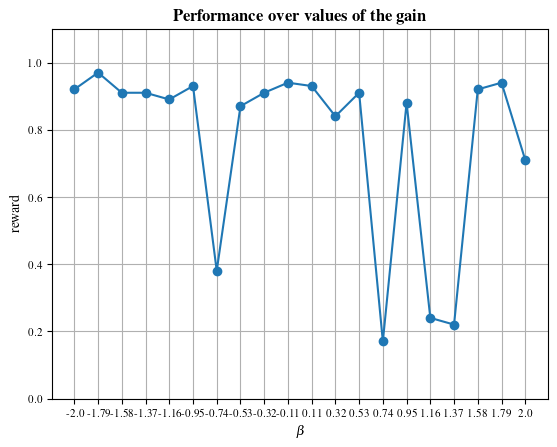

In [15]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})
plt.plot(gain_values, z, '-o')
plt.xticks(gain_values, np.around(gain_values, 2))
plt.xlabel(r"$\beta$")
plt.ylabel("reward")
plt.ylim((0, 1.1))
plt.grid()
plt.title(r"\textbf{Performance over values of the gain}")
plt.show()

In [643]:
p = utils.make_probability_set(K=10,
                           nb_trials=1,
                           fixed_p=0.9,
                           normalize=False)
utils.calc_entropy(p)

2.052248035680213

---

In [645]:

def make_env(K: int,
             env_type: str,
             probabilities_set: list=None,
             tau: int=None,
             normalize=True):

    if env_type == "driftv0":
        env = envs.KABdriftv0(K=K,
                              probabilities_set=probabilities_set,
                              verbose=False,
                              tau=tau)
    elif env_type == "driftv1":
        env = envs.KABdriftv1(K=K,
                              verbose=False,
                              tau=tau,
                              normalize=normalize,
                              fixed_p=0.9)
    elif env_type == "sinv0":
        frequencies = np.linspace(0.1, 0.4, K)
        phases = np.random.uniform(0, 2*np.pi, K)
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            phases=phases,
                            normalize=normalize,
                            verbose=False)
    elif env_type == "sinv1":
        frequencies = np.linspace(0.1, 0.4, K)
        phases = np.random.uniform(0, 2*np.pi, K)
        constants = np.random.uniform(0.1, 0.7, int(K/2))
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            phases=phases,
                            normalize=normalize,
                            constants=constants,
                            verbose=False)
    else:
        env = envs.KABv0(K=K,
                         probabilities_set=probabilities_set,
                         verbose=False)

    return env

In [650]:
K = 10
frequencies = np.linspace(0.1, 0.4, K)
phases = np.random.uniform(0, 2*np.pi, K)
constants = np.random.uniform(0.1, 0.7, int(K/2))
env = envs.KABsinv0(K=K,
                    frequencies=frequencies,
                    phases=phases,
                    normalize=True,
                    constants=constants,
                    verbose=False)

In [651]:
utils.calc_entropy(env.probabilities)

2.0083564163542884

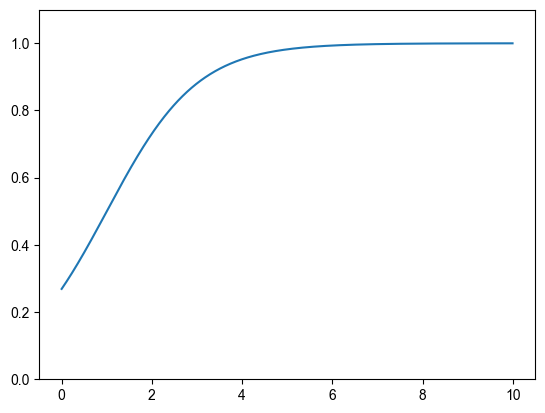

In [9]:
x = np.arange(0, 10, 0.01)
y = utils.neural_response_func(x, 1, 1, 0.)
plt.plot(x, y)
plt.ylim(0, 1.1)
plt.show()

In [10]:
model_params.keys()

dict_keys(['tau_u', 'tau_v', 'gain_v', 'offset_v', 'threshold_v', 'gain_u', 'offset_u', 'threshold_u', 'alpha', 'beta', 'mu', 'sigma', 'r', 'alpha_lr', 'beta_lr', 'mu_lr', 'sigma_lr', 'r_lr', 'w_max', 'dur_pre', 'dur_post'])

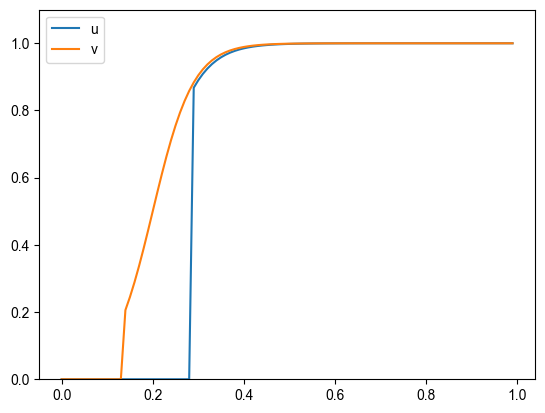

In [11]:
x = np.arange(0, 1, 0.01)

yu = utils.neural_response_func(x=x, offset=model_params['offset_u'], gain=model_params['gain_u'], threshold=model_params['threshold_u'])
yv = utils.neural_response_func(x=x, offset=model_params['offset_v'], gain=model_params['gain_v'], threshold=model_params['threshold_v'])

plt.plot(x, yu, label=r"u")
plt.plot(x, yv, label=r"v")
plt.legend()
plt.ylim(0, 1.1)
plt.show()

#### what's the activation scale?

In [5]:
nb_rounds = 1000
nb_trials = 2
K = 50

probabilities_set = utils.make_probability_set(K=K,
                                               nb_trials=nb_trials,
                                               fixed_p=0.9,
                                               normalize=False)

env = envs.KABv0(K=K,
                 probabilities_set=probabilities_set,
                 verbose=False)

model_params = utils.load_model(idx=16)
model_params['K'] = K
model = mm.Model(**model_params)

for trial_i in range(nb_trials):

        if trial_i > 0:
            env.update()

        score = 0.
        for round_i in tqdm(range(nb_rounds)):

            k = model.select_arm()
            reward = env.sample(k=k)
            model.update(k=k, reward=reward)

            score += reward
            
        score /= nb_rounds
        logger(f"[{trial_i}] {score=:.3f}")

2024-12-11 22:22:38 | Invalid parameters for Model, using Modelv2 instead
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.38it/s]
2024-12-11 22:23:06 | [0] score=0.858
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.80it/s]
2024-12-11 22:23:33 | [1] score=0.591


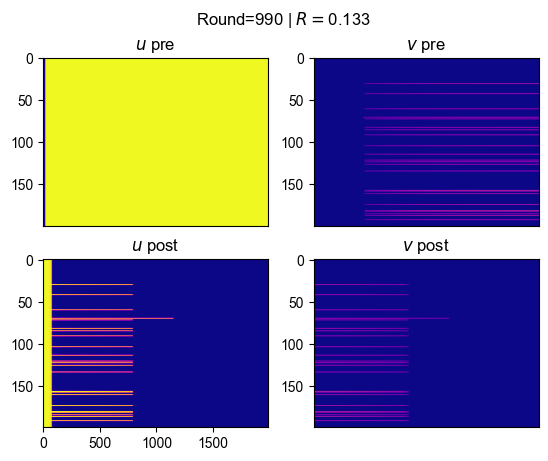

TypeError: unsupported operand type(s) for /=: 'list' and 'int'

In [7]:
nb_rounds = 1000
nb_trials = 2
K = 200

probabilities_set = utils.make_probability_set(K=K,
                                               nb_trials=nb_trials,
                                               fixed_p=0.9,
                                               normalize=False)

env = envs.KABv0(K=K,
                 probabilities_set=probabilities_set,
                 verbose=False)

model_params = utils.load_model(idx=16)
model_params['K'] = K
model = mm.Model(**model_params)
window = 30
for trial_i in range(nb_trials):

        if trial_i > 0:
            env.update()

        score = [0]*window
    
        for round_i in range(nb_rounds):

            k, record = model.select_arm(record=True)
            reward = env.sample(k=k)
            model.update(k=k, reward=reward)

            score += [reward]
            if len(score) > window: del score[0]
            
            # plot
            if round_i % 10 == 0:
                clear_output(wait=True)
                fig = plt.figure()
                fig.suptitle(f"Round={round_i} | $R=${sum(score)/window:.3f}")
                
                plt.subplot(221)
                plt.imshow(record['u']['pre'], cmap="plasma", vmin=0, vmax=1, aspect="auto")
                plt.title("$u$ pre")
                plt.xticks(())
                plt.subplot(222)
                plt.imshow(record['v']['pre'], cmap="plasma", vmin=0, vmax=1, aspect="auto")
                plt.title("$v$ pre")
                plt.xticks(())
                
                plt.subplot(223)
                plt.imshow(record['u']['post'], cmap="plasma", vmin=0, vmax=1, aspect="auto")
                plt.title("$u$ post")
                plt.subplot(224)
                plt.xticks(())

                plt.imshow(record['v']['post'], cmap="plasma", vmin=0, vmax=1, aspect="auto")
                plt.title("$v$ post")
                plt.xticks(())
    
                plt.pause(0.001)
            
            
            
        score = sum(score) / nb_rounds
        logger(f"[{trial_i}] {score=}")

2024-12-11 22:26:19 | selection=0


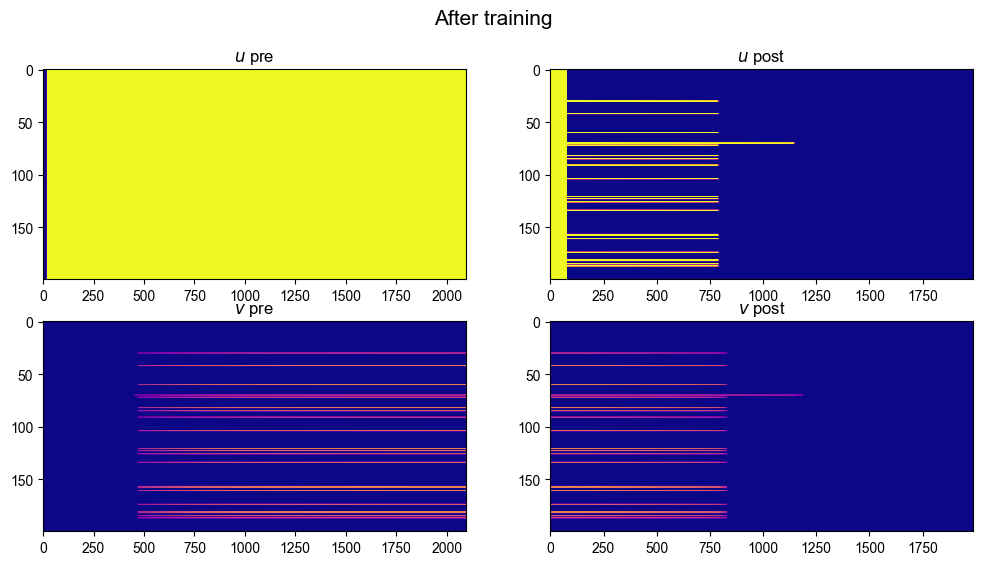

In [8]:
selection, record = model.select_arm(record=True)
pre_u = record['u']['pre']
post_u = record['u']['post']
pre_v = record['v']['pre']
post_v = record['v']['post']

logger(f"{selection=}")

""" plot """
fig, (axu, axv) = plt.subplots(2, 2, figsize=(12, 6))

VMIN = 0
VMAX = 0.5
axu[0].imshow(pre_u, cmap="plasma", vmin=VMIN, vmax=VMAX,  aspect="auto")
axu[0].set_title("$u$ pre")
axv[0].imshow(pre_v, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axv[0].set_title("$v$ pre")

axu[1].imshow(post_u, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axu[1].set_title("$u$ post")
axv[1].imshow(post_v, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axv[1].set_title("$v$ post")
fig.suptitle("After training", fontsize=15)
plt.show()

In [12]:
""" activity before training """
model_params = utils.load_model(idx=16)
model_params['K'] = 20
model = mm.Model(**model_params)

2024-12-11 22:19:21 | Invalid parameters for Model, using Modelv2 instead


2024-12-11 22:19:22 | selection=0


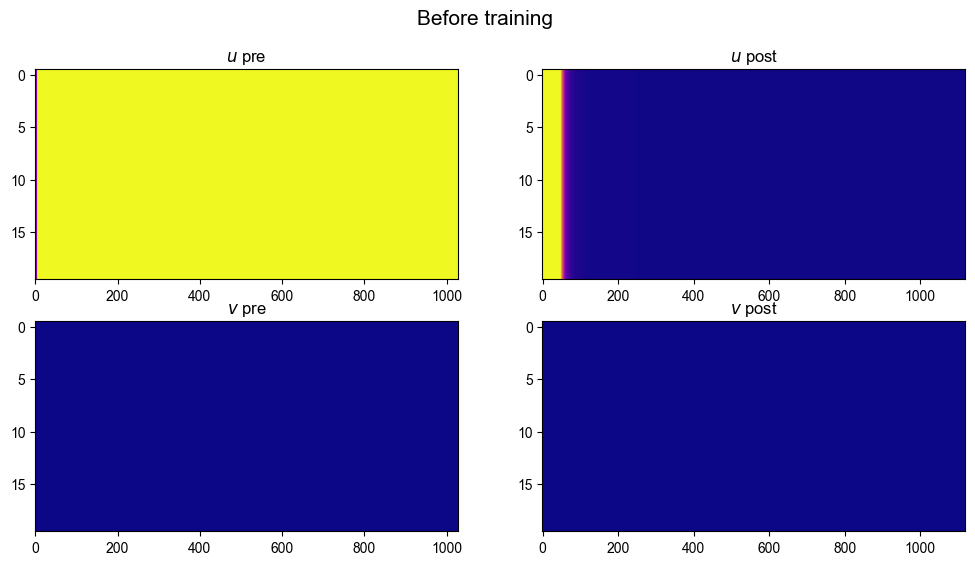

In [13]:
selection, record = model.select_arm(record=True)
pre_u = record['u']['pre']
post_u = record['u']['post']
pre_v = record['v']['pre']
post_v = record['v']['post']

logger(f"{selection=}")

""" plot """
fig, (axu, axv) = plt.subplots(2, 2, figsize=(12, 6))

VMIN = 0
VMAX = 0.5
axu[0].imshow(pre_u, cmap="plasma", vmin=VMIN, vmax=VMAX,  aspect="auto")
axu[0].set_title("$u$ pre")
axv[0].imshow(pre_v, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axv[0].set_title("$v$ pre")

axu[1].imshow(post_u, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axu[1].set_title("$u$ post")
axv[1].imshow(post_v, cmap="plasma", vmin=VMIN, vmax=VMAX, aspect="auto")
axv[1].set_title("$v$ post")
fig.suptitle("Before training", fontsize=15)
plt.show()

---
## **Other**

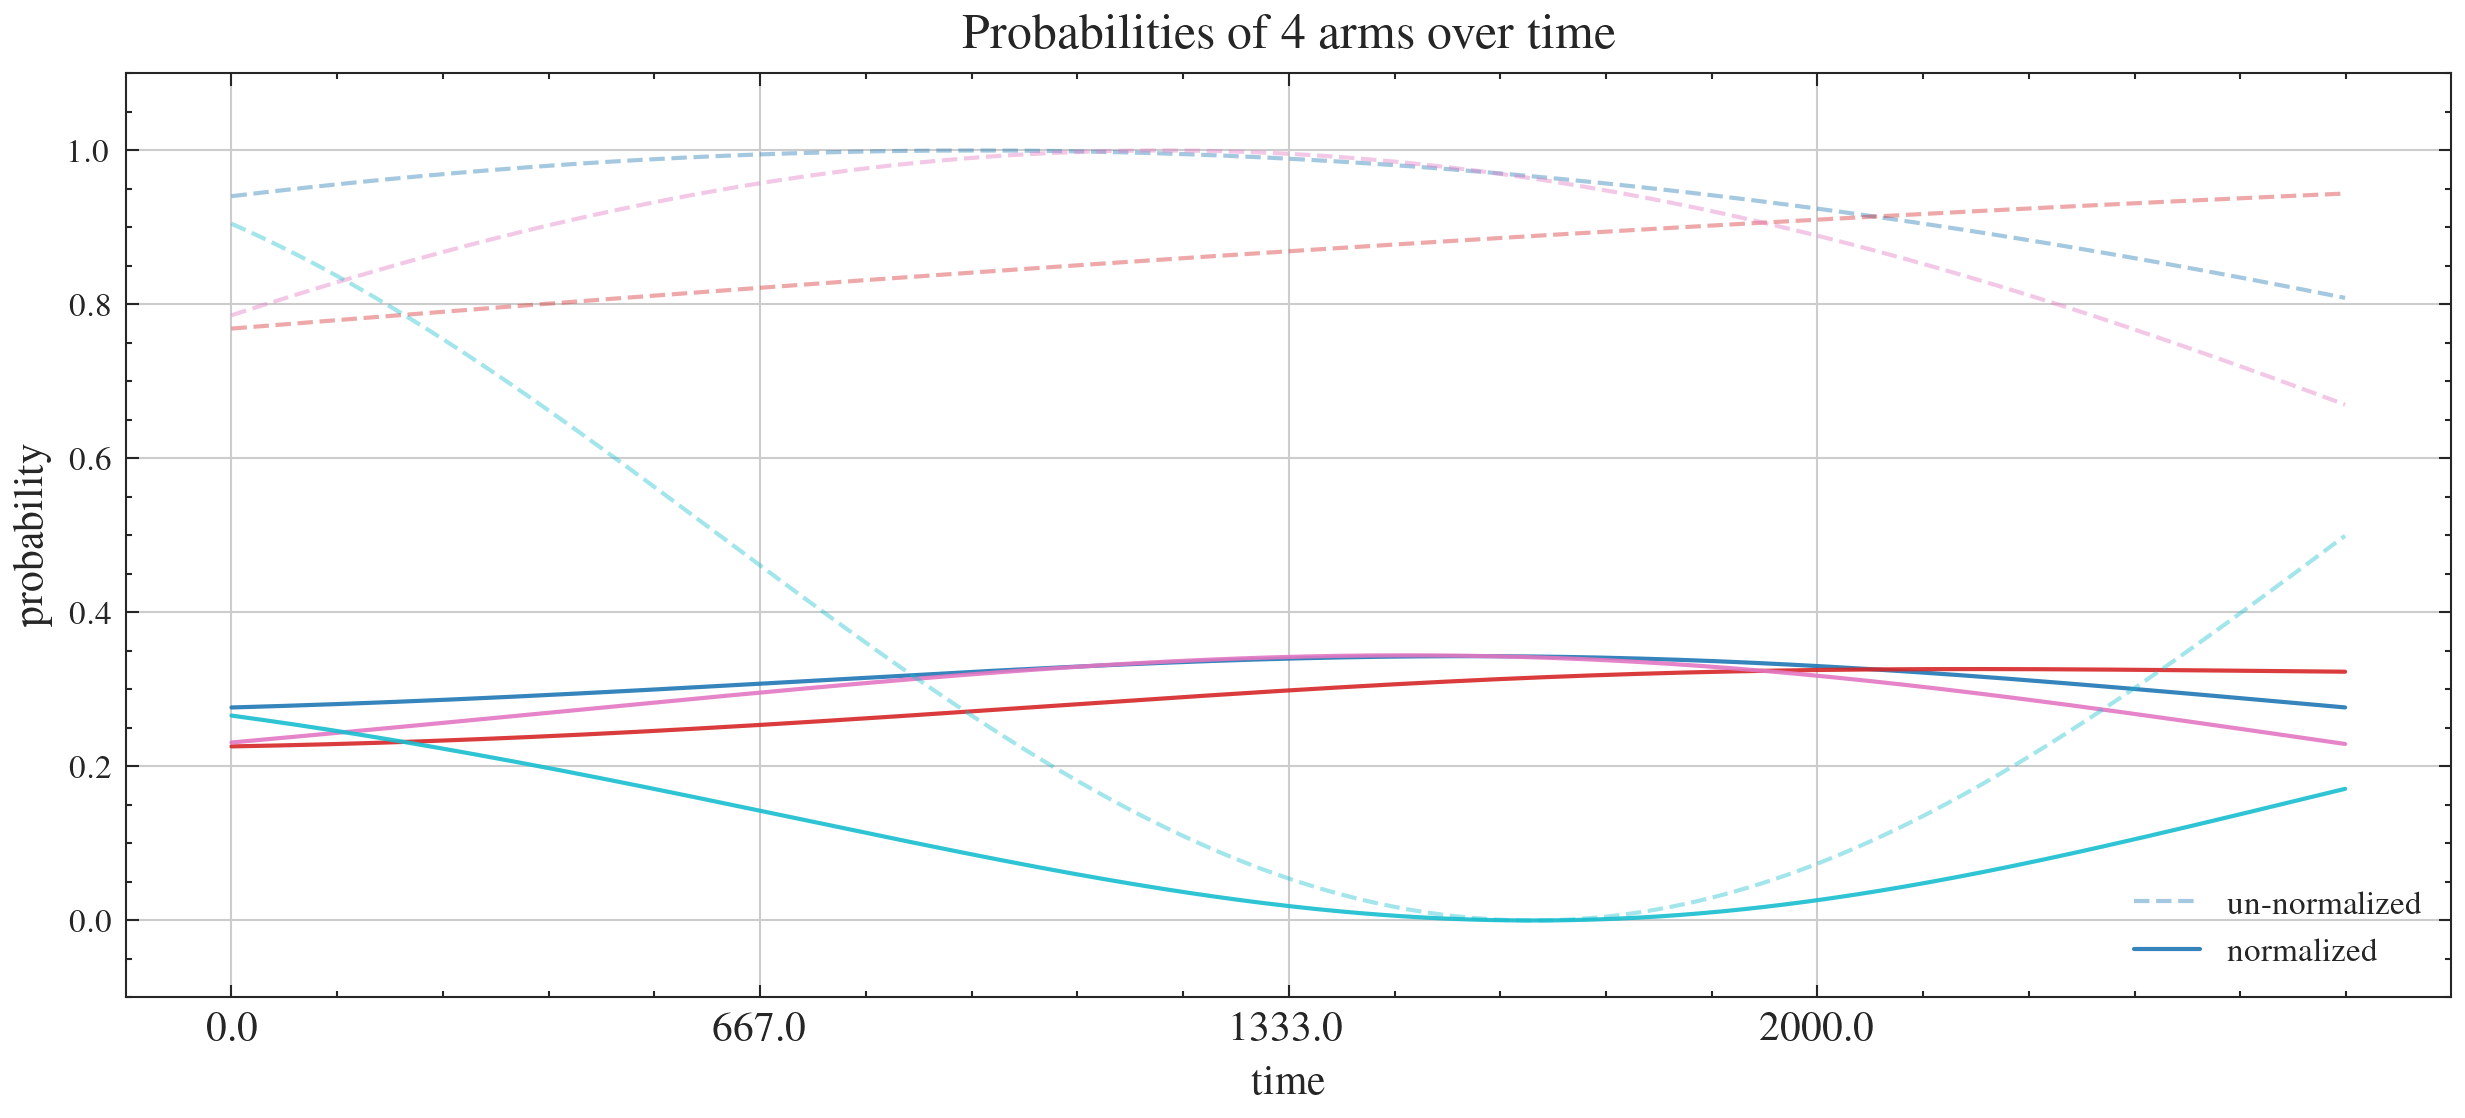

In [497]:
N = 4
#F = list(range(N))
H = np.zeros(N)

F = np.random.uniform(0.01, 0.4, N)
H = np.random.uniform(0, N, N)


x = np.arange(0, 2, 0.001)
y = np.zeros((len(F), len(x)))


fig, ax = plt.subplots(figsize=(10, 4))

for i in range(N):
    y[i] = 0.5*np.sin(2*np.pi*x*F[i] + H[i]) + 0.5

z = y/y.sum(axis=0)

colors = plt.cm.tab10(np.linspace(0, 1, N))

for i, (zi, yi) in enumerate(zip(z, y)):
    if i > 0:
        ax.plot(x, yi, linestyle='--', color=colors[i], alpha=0.4)
        ax.plot(x, zi, color=colors[i], alpha=0.9)
        continue
    ax.plot(x, yi, linestyle='--', color=colors[i], alpha=0.4,
           label="un-normalized")
    ax.plot(x, zi, color=colors[i], alpha=0.9, label="normalized")

ax.set_ylim((-0.1, 1.1))
xl = np.arange(0, max(x), 0.5)
ax.set_xticks(xl)
ax.set_xticklabels(np.around(np.linspace(0, len(x), len(xl)), 0))
ax.set_xlabel("time")
ax.set_ylabel("probability")
ax.set_title(f"Probabilities of {N} arms over time")
ax.grid()
ax.legend(loc="lower right")
plt.show()

In [78]:
xl

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [287]:
fig.savefig("paper/figures/kab_sinv0.png", dpi=500)
print("done")

done


In [311]:
a = np.arange(0, 10, 1)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [312]:
np.mode(a)

AttributeError: module 'numpy' has no attribute 'mode'

In [2]:
env = envs.KABsinv0(K=4, frequencies=list(range(4)), normalize=True)
print(env)

KABsinv0


In [40]:
args.K

5